# Initial Condition Sensitivity analysis on a Batch of data 

In [8]:
import sys
if 'init_modules' in globals().keys():
    # second or subsequent run: remove all but initially loaded modules
    for m in sys.modules.keys():
        if m not in init_modules:
            del(sys.modules[m])
else:
    # first run: find out which modules were initially loaded
    init_modules = sys.modules.keys()
import os
from sys import platform

import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import h5py
import pandas as pd
import random

from joblib import Parallel, delayed
import multiprocessing

import pyfilaments.analysisutils as analysis
from pyfilaments.activeFilaments import activeFilament

import imp
imp.reload(analysis)
%matplotlib notebook
plt.close('all')

# Figure parameters
from matplotlib import rcParams
from matplotlib import rc
from matplotlib import cm
from tqdm import tqdm

rc('font', family='sans-serif') 
rc('font', serif='Helvetica') 
rc('text', usetex='false') 
rcParams.update({'font.size': 12})

# Check which platform
if platform == "linux" or platform == "linux2":
    print("linux system")
    # root_path = '/home/deepak/Dropbox/LacryModeling/ModellingResults'
    root_path = '/home/deepak/ActiveFilamentsSearch_backup_3/ModellingResults'

elif platform == 'darwin':
    print("OSX system")
    root_path = '/Users/deepak/Dropbox/LacryModeling/ModellingResults'

linux system


In [9]:
# Global parameters
DELTA_IC = 1e-2 # Average distance between nearby ICs.

N_transient = 400 # No:of activity cycles for transients to decay. 

N_IC_time = 10 # IC based on different activity cycles/time
N_IC_phase = 1 # Different IC within each activity phase

N_IC_nearby = 10

N_ACTIVITY_CYCLES = 20 # No:of activity cycles to simulate for IC sensitivity analysis

## Function definitions

In [10]:
def choose_ic_time_phase(fil):
    """Takes a filament simulation and returns randomly chosen time points at a randomly chosen phase
        along the activity cycle.
    """
    N_cycles = int(fil.Time[-1]/fil.activity_timescale)

    # Choose n random activity cycles (time)
    n_cycles = random.sample(range(N_transient, N_cycles), N_IC_time)

    # Within each activity cycle choose points evenly distributed in phase
    n_phase = random.sample(list(np.linspace(0, 2*np.pi, 100)), N_IC_phase)

    # Compute the minimum resolved phase difference in the simulations
    delta_phase = 2*np.pi*np.mean(fil.Time[1:] - fil.Time[:-1])/fil.activity_timescale # Smallest change in phase

    time_points = np.array(range(0, len(fil.Time)))
    # Find the index corresponding to each unique IC

    # Create empty array to store indices for each unique IC
    ic_mesh = np.empty((N_IC_time, N_IC_phase), dtype = int)

    # Phase array for the whole simulation
    phase_array = 2*np.pi*(fil.Time%fil.activity_timescale)/fil.activity_timescale

    for ii, phase in enumerate(n_phase):

        abs_val_array = np.abs(fil.derived_data['Phase'] - phase)
        constant_phase_mask = abs_val_array <= 0.5*delta_phase
        time_indices = time_points[constant_phase_mask]
        ic_mesh[:, ii] = time_indices[n_cycles]
        
    return ic_mesh


def generate_close_ic(fil = None, ic_mesh = None, rn_seed = 0):
    """ Start with a filament shape at the randomly chosen time-points and generate closely spaced ICs 
        by adding random perturbation with a small amplitide \delta_IC
        
        Store these ICs as .hdf5 files in the IC_analysis folder within the simulation data folder.
        
        Returns: Nothing
    """
    if not(os.path.exists(fil.ic_analysis_folder)):
           os.makedirs(fil.ic_analysis_folder)
    # Use a fixed seed to generate repeatable random numbers
    np.random.seed(rn_seed)

    filament_init_shape = np.zeros(fil.Np*fil.dim, dtype = np.double)

    delta_theta_array = DELTA_IC*np.random.randn(N_IC_nearby)
    
    phase_array = 2*np.pi*(fil.Time%fil.activity_timescale)/fil.activity_timescale

    
    
    for ii in range(N_IC_time):

        for jj in range(N_IC_phase):

            time_index = ic_mesh[ii, jj]

            phase = phase_array[time_index]

            ic_folder = os.path.join(fil.ic_analysis_folder, 'IC_{}'.format(time_index))

            if(not os.path.exists(ic_folder)):
               os.makedirs(ic_folder)

            filament_shape = fil.R[time_index,:]
#             plt.figure(figsize=(2,2))
#             fil.plotFilament(r = filament_shape)
#             plt.title(time_index)
#             plt.axis('equal')

            for kk in range(N_IC_nearby):
                #-------------------------------
                # Method 1 : Random transverse perturbation
                #-------------------------------
                 # Add noise along X direction
                filament_init_shape[1:fil.Np] = \
                filament_shape[1:fil.Np]+ np.random.normal(0, DELTA_IC, fil.Np-1)
                # Add noise along Y direction
                filament_init_shape[fil.Np+1:2*fil.Np] = \
                filament_shape[fil.Np+1:2*fil.Np]+ np.random.normal(0, DELTA_IC, fil.Np-1)
                #-------------------------------
                # Method 2 : Add a solid body rotation.
                #-------------------------------
    #             delta_theta = delta_theta_array[kk]

    #             x_pos = filament_init_shape[0:fil.Np]
    #             y_pos = filament_init_shape[fil.Np:2*fil.Np]

    #             delta_x = -delta_theta*y_pos
    #             delta_y = delta_theta*x_pos

    #             filament_init_shape[0:fil.Np] = filament_shape[0:fil.Np] + delta_x
    #             filament_init_shape[fil.Np:2*fil.Np] = filament_shape[fil.Np:2*fil.Np] + delta_y
    
                save_file = 'filament_ic_{0:03d}.hdf5'.format(kk)
                # Save the resulting filament shapes to disk
                with h5py.File(os.path.join(ic_folder, save_file), "w") as f:

                    dset = f.create_group("simulation data")
                    dset.create_dataset("Initial Position", data = filament_init_shape)
                    dset.attrs['Time index'] = time_index
                    # Also save the phase value of the simulation
                    dset.attrs['Phase'] = phase
                    

def create_batchsim_table(folders = None, fil = None):
    
    """ Create a table/dict of IC for filament shape along with phase info that can be passed to run a Parallel job
        
        Input: Folder containing IC files. This folder should contain IC that are closely spaced together. 
        
        Returns: ic_list (dict containing: path, filename, filament shape and phase of each IC)
    
    """
    # Create a dictionary to store all IC we want to simulate
    ic_table = {}
    ic_counter = 0
    
    root_folder = fil.ic_analysis_folder
    
    
    
    if not(os.path.exists(fil.ic_analysis_folder)):
           os.makedirs(fil.ic_analysis_folder)

    for folder in folders:

        ic_files = os.listdir(os.path.join(root_folder, folder))
     
        for file in ic_files:
            
            if(file.endswith('.hdf5')):
                with h5py.File(os.path.join(root_folder, folder, file), "r") as f:
                    if('simulation data' in f.keys()): # Load the simulation data
                        dset = f['simulation data']
                        r = np.array(dset["Initial Position"][:])
                        time_point = int(dset.attrs["Time index"])
                        phase = dset.attrs['Phase']


                ic_table[ic_counter] = {'path':os.path.join(root_folder, folder), 'ic':file[:-5], 'filament shape':r, 'phase':phase}


                ic_counter+=1
            
    return ic_table

# Function version of above 
def run_ic_simulation_batch(fil = None, ic_table = None):
    """ Runs a batch/parallel simulation on a set of N_IC closely spaced ICs specified using ic_table 
        for a given filament
        Inputs: filament object containing the filament corresponding to the current parameter value
                ic_table: List of ICs to simulate
                
        Returns: Nothing. Saves results of the IC simulations to disk.
    """
    #-----------------------------------------------------------------------------------------------------
    def run_ic_simulation(ic, path, filament_shape, phase):
#     """Run a filament simulation using specified parameters
#     """
        # Simulate each IC
        new_fil = activeFilament(dim = dim, Np = Np, radius = radius, b0 = b0, k = k, S0 = S0, D0 = D0, bc = bc)

        new_fil.simulate(Tf, Npts, n_cycles = n_activity_cycles, save = True, overwrite = False, path = path, sim_type = 'point', 
        init_condition = {'filament':filament_shape}, 
        activity={'type':'square-wave','activity_timescale':activity_timescale, 'duty_cycle':0.5, 'start phase':phase},
                     note = ic, create_subdirs=False, ic_sim = True)
    #-----------------------------------------------------------------------------------------------------
    # No:of activity cycles we want to simulate
    n_activity_cycles = N_ACTIVITY_CYCLES
    # Total simulation time
    Tf = fil.activity_timescale*n_activity_cycles

    # Total simulation time
    # No:of time points saved
    time_step_save = 10
    Npts = int(Tf/time_step_save)

    bc = {0:'clamped', -1:'free'}

    dim = fil.dim
    Np = fil.Np
    radius = fil.radius
    b0 = fil.b0
    k = fil.k
    S0 = fil.S0
    D0 = fil.D0
    activity_timescale = fil.activity_timescale
    
    # Run the Parallel/Batch simulations
    num_cores = multiprocessing.cpu_count()
    print(num_cores)
    num_cores = 12
    results = Parallel(n_jobs = num_cores,  verbose=10)(delayed(run_ic_simulation)(ic_table[ic_index]['ic'], ic_table[ic_index]['path'], ic_table[ic_index]['filament shape'], ic_table[ic_index]['phase']) for ic_index in tqdm(ic_table.keys()))


## Run the Batch Simulations for Initial Condition Sensitivity

### Batch simulation procedure

For each simulation parameter 

### Step 1: Generate closely spaced ICs
1. Find one instance of a completed simulation. If no completed simulations then skip this parameter.
2. Load this simulation file to memory.
3. Choose random points separated in time.
4. Generate and save closely separated filament ICs by adding small perturbations of amplitude \delta_IC.

### Step 2: Run simulations starting from the closely spaced ICs for each parameter values.
1. Run simulations starting from each of these ICs for all the random time points.
2. Save the Results to file







In [11]:
# batch_data_folder = '/home/deepak/ActiveFilamentsSearch_backup_3/ModellingResults/Analysis_test'

# Full data
batch_data_folder = '/home/deepak/ActiveFilamentsSearch_backup_3/ActivityStrengthSweep_widerICS_FINAL_2021-12-23'
data_folders = os.listdir(batch_data_folder)

print(len(data_folders))

37


### Step 1: Generate closely spaced ICs

In [ ]:
# Step 1: Generate closely spaced ICs

plt.close('all')
for folder in tqdm(data_folders):
    
    cwd = os.path.join(batch_data_folder, folder)
    os.chdir(cwd)
    found_completed_sim = False
    
    files = [file for file in os.listdir(cwd) if file.endswith('.hdf5')]
    plt.close('all')
    while found_completed_sim == False:
        
        for file in files:
            
            full_path = os.path.join(batch_data_folder, folder, file)
            
            fil = analysis.analysisTools(file = full_path)
            
            ic_analysis_folder = os.path.join(fil.rootFolder, 'IC_analysis')
    
            fil.ic_analysis_folder = ic_analysis_folder
            
            if(fil.Time[-1]==500*fil.activity_timescale):
                # If simulation has at least 500 activity cycles then use it to generate ICs
                print(50*'*')
                print('Completed simulation found!')
                print('Generating closely spaced initial conditions...')
                print(50*'*')
                # Generate and save the ICs
                
                ic_mesh = choose_ic_time_phase(fil)
                generate_close_ic(fil = fil, ic_mesh = ic_mesh)
                
                # Also store the exact completed simulation file we are using to generate ICs
                df_sim_file = pd.DataFrame({'sim file':[file]})
                
                df_sim_file.to_csv(os.path.join(fil.ic_analysis_folder,'sim_file.csv'))
                found_completed_sim = True
                # ----------------------------------------------- We can break the workflow here
                
            if found_completed_sim==True:
                break
                
#                 create_batchsim_table(folders = ic_folders, fil = fil) 

  5%|▌         | 2/37 [00:00<00:02, 13.12it/s]

**************************************************
Completed simulation found!
Generating closely spaced initial conditions...
**************************************************
**************************************************
Completed simulation found!
Generating closely spaced initial conditions...
**************************************************
**************************************************
Completed simulation found!
Generating closely spaced initial conditions...
**************************************************


 11%|█         | 4/37 [00:00<00:02, 13.29it/s]

**************************************************
Completed simulation found!
Generating closely spaced initial conditions...
**************************************************


 11%|█         | 4/37 [00:20<00:02, 13.29it/s]

### Step 2: Run IC simulations starting from the generated ICs

In [48]:
# Step 2: Run IC simulations starting from the generated ICs

for folder in data_folders:
    
    cwd = os.path.join(batch_data_folder, folder)
    os.chdir(cwd)
    
    if(os.path.exists(os.path.join(cwd, 'IC_analysis'))):
        df_sim_file = pd.read_csv(os.path.join(cwd, 'IC_analysis', 'sim_file.csv'))
        
        full_path = os.path.join(cwd, df_sim_file['sim file'][0])
            
        fil = analysis.analysisTools(file = full_path)
        
        ic_analysis_folder = os.path.join(fil.rootFolder, 'IC_analysis')
        
        fil.ic_analysis_folder = ic_analysis_folder
        
        ic_folders = [folder for folder in os.listdir(fil.ic_analysis_folder) if not folder.endswith('.csv')]
        
        print(ic_folders)
        ic_table = create_batchsim_table(folders=ic_folders, fil = fil)
        
        run_ic_simulation_batch(ic_table= ic_table, fil = fil)

  0%|          | 0/100 [00:00<?, ?it/s]

3
Loading Simulation data from disk .......
Loading hdf5 file
Activity profile data found!
Time step: 9.999733340444255
No:of particles : 32
No:of time points : 37501
Root path:  /home/deepak/ActiveFilamentsSearch_backup_3/ModellingResults/Analysis_test/SimResults_Np_32_Shape_line at angle_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_1.59_activityTime_750_simType_point
Data file SimResults_07_.hdf5
['IC_33745', 'IC_34945', 'IC_32395', 'IC_36895', 'IC_32245', 'IC_35845', 'IC_35545', 'IC_32320', 'IC_33220', 'IC_30145']
IC_33745
['filament_ic_006.hdf5', 'filament_ic_000.hdf5', 'filament_ic_007.hdf5', 'filament_ic_008.hdf5', 'filament_ic_005.hdf5', 'filament_ic_001.hdf5', 'filament_ic_002.hdf5', 'filament_ic_009.hdf5', 'filament_ic_003.hdf5', 'filament_ic_004.hdf5']
IC_34945
['filament_ic_006.hdf5', 'filament_ic_000.hdf5', 'filament_ic_007.hdf5', 'filament_ic_008.hdf5', 'filament_ic_005.hdf5', 'filament_ic_001.hdf5', 'filament_ic_002.hdf5', 'filament_ic_009.hdf5', 'filament_ic_003.hdf5', 'filament_ic

[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
 48%|████▊     | 48/100 [08:26<10:44, 12.40s/it][Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:  9.0min
[Parallel(n_jobs=12)]: Done  37 tasks      | elapsed: 12.0min
100%|██████████| 100/100 [22:02<00:00, 13.23s/it]
[Parallel(n_jobs=12)]: Done  74 tasks      | elapsed: 22.5min
[Parallel(n_jobs=12)]: Done  88 out of 100 | elapsed: 25.9min remaining:  3.5min
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed: 28.7min finished
  0%|          | 0/100 [00:00<?, ?it/s][Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.


3
Loading Simulation data from disk .......
Loading hdf5 file
Activity profile data found!
Time step: 9.999733340444255
No:of particles : 32
No:of time points : 37501
Root path:  /home/deepak/ActiveFilamentsSearch_backup_3/ModellingResults/Analysis_test/SimResults_Np_32_Shape_line at angle_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_0.821_activityTime_750_simType_point
Data file SimResults_07_.hdf5
['IC_34257', 'IC_32532', 'IC_36732', 'IC_34182', 'IC_30432', 'IC_30132', 'IC_30582', 'IC_32232', 'IC_33657', 'IC_30732']
IC_34257
['filament_ic_006.hdf5', 'filament_ic_000.hdf5', 'filament_ic_007.hdf5', 'filament_ic_008.hdf5', 'filament_ic_005.hdf5', 'filament_ic_001.hdf5', 'filament_ic_002.hdf5', 'filament_ic_009.hdf5', 'filament_ic_003.hdf5', 'filament_ic_004.hdf5']
IC_32532
['filament_ic_006.hdf5', 'filament_ic_000.hdf5', 'filament_ic_007.hdf5', 'filament_ic_008.hdf5', 'filament_ic_005.hdf5', 'filament_ic_001.hdf5', 'filament_ic_002.hdf5', 'filament_ic_009.hdf5', 'filament_ic_003.hdf5', 'filament_i

[Parallel(n_jobs=12)]: Done   1 tasks      | elapsed:  2.9min
 48%|████▊     | 48/100 [09:32<11:30, 13.28s/it][Parallel(n_jobs=12)]: Done  26 tasks      | elapsed: 10.3min
[Parallel(n_jobs=12)]: Done  37 tasks      | elapsed: 13.8min
100%|██████████| 100/100 [25:38<00:00, 15.38s/it]
[Parallel(n_jobs=12)]: Done  74 tasks      | elapsed: 26.5min
[Parallel(n_jobs=12)]: Done  88 out of 100 | elapsed: 30.5min remaining:  4.2min
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed: 33.6min finished
  0%|          | 0/100 [00:00<?, ?it/s][Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.


3
Loading Simulation data from disk .......
Loading hdf5 file
Activity profile data found!
Time step: 9.999733340444255
No:of particles : 32
No:of time points : 37501
Root path:  /home/deepak/ActiveFilamentsSearch_backup_3/ModellingResults/Analysis_test/SimResults_Np_32_Shape_line at angle_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point
Data file SimResults_01_.hdf5
['IC_30127', 'IC_34777', 'IC_31927', 'IC_34402', 'IC_31402', 'IC_36502', 'IC_30727', 'IC_37327', 'IC_31252', 'IC_33352']
IC_30127
['filament_ic_006.hdf5', 'filament_ic_000.hdf5', 'filament_ic_007.hdf5', 'filament_ic_008.hdf5', 'filament_ic_005.hdf5', 'filament_ic_001.hdf5', 'filament_ic_002.hdf5', 'filament_ic_009.hdf5', 'filament_ic_003.hdf5', 'filament_ic_004.hdf5']
IC_34777
['filament_ic_006.hdf5', 'filament_ic_000.hdf5', 'filament_ic_007.hdf5', 'filament_ic_008.hdf5', 'filament_ic_005.hdf5', 'filament_ic_001.hdf5', 'filament_ic_002.hdf5', 'filament_ic_009.hdf5', 'filament_ic_003.hdf5', 'filament_i

[Parallel(n_jobs=12)]: Done   1 tasks      | elapsed:   45.3s
 48%|████▊     | 48/100 [07:32<09:48, 11.33s/it][Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:  8.1min
[Parallel(n_jobs=12)]: Done  37 tasks      | elapsed: 10.8min
100%|██████████| 100/100 [20:46<00:00, 12.46s/it]
[Parallel(n_jobs=12)]: Done  74 tasks      | elapsed: 21.2min
[Parallel(n_jobs=12)]: Done  88 out of 100 | elapsed: 24.8min remaining:  3.4min
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed: 27.1min finished


## Run the Batch Analysis for Initial Condition Sensitivity

### Step 1: For each folder containing simulations at a paramater value

- For each IC separated in time
    - calculate pairwise distances for all closely spaced IC simulations
    - save the results to file
    - Estimate the Lyapunov exponent slope of the linear (in log space) part of these trajectories using WLS-ICE
    - Store the estimated slope and confidence interval of the estimate.
    
### Step 2: Collate and Plot the results

Trawl through the data-folder and collate all the Lyapunov exponent data
Store this in a DataFrame along with all the metadata required.
Save this DataFrame for future analysis.


    


## Analysis Function Definitions

In [104]:
os.chdir('/home/deepak/PyFilaments/processing')
import itertools
import pandas as pd
import wlsice.python.wlsice as wlsice


# Function version of above script
def calculate_pairwise_distance(ic_sim_folder = None):
    
    """ For a set of filament simulations starting from closely-spaced ICs, 
        calculate the pair-wise distances between different simulations.
        
        Inputs:
        ic_analysis_folder: base folder containing all the ICs spread across time
        folder: folder containing closely spaced ICs and the simulation results. 
        Folder structure:
        - SimdataFolder > IC_analysisFolder > IC_12345 > IC_simdata
        
        
        Returns: pairwise_distance_df. Also stores the pairwise-distances to file
    """
    root_folder, temp = os.path.split(ic_sim_folder) # Folder containing the closely spaced IC simulations
    
    save_filename = 'pairwise_distance.csv'
    
    

    ic_sim_files = [file for file in os.listdir(ic_sim_folder) if file.endswith('.hdf5')]

    print(50*'*')
    print('Loading IC simulation files...')
    print(ic_sim_files)
    print(50*'*')

    # Load 'the first file to extract parameters
    fil = analysis.analysisTools(file = os.path.join(ic_sim_folder, ic_sim_files[0]))

    # Create an array to store the pair-wise distance among all IC
    N_IC = len(ic_sim_files)
    
    max_sim_duration = 0
    N_time = 0
    for file in ic_sim_files:
        fil = analysis.analysisTools(file = os.path.join(ic_sim_folder, file))
        max_sim_duration = max(max_sim_duration, fil.Time[-1])
        N_time = max(len(fil.Time), N_time)
        
    print('Maximum duration of simulation:', max_sim_duration)
        

    # Unique pairs
    N_pairs = int(N_IC*(N_IC - 1)/2)



    pairwise_distance_array = np.empty((N_pairs, N_time))

    fil_pairs = list(itertools.combinations(ic_sim_files, 2))

    pairwise_distance_df = pd.DataFrame({})

    counter = 0
    for ii in tqdm(range(len(fil_pairs))):

        fil_1 = analysis.analysisTools(file = os.path.join(ic_sim_folder, fil_pairs[ii][0]))
        fil_2 = analysis.analysisTools(file = os.path.join(ic_sim_folder, fil_pairs[ii][1]))

        # Only analyze simulations of the same duration

        if(fil_1.Time[-1]==max_sim_duration and fil_2.Time[-1]==max_sim_duration):

            for jj in range(N_time):
                r1 = fil_1.R[jj,:]
                r2 = fil_2.R[jj,:]

                pairwise_distance_array[counter, jj] = fil_1.euclidean_distance(r1, r2)

            ic_pair = fil_pairs[ii][0]+','+fil_pairs[ii][1]
            
            pairwise_distance_df = \
            pairwise_distance_df.append(pd.DataFrame({'Time':fil_1.Time, 
                 'IC pair':np.repeat(ic_pair, N_time), 
                  'activity timescale':np.repeat(fil.activity_timescale, N_time),
                     'Distance':pairwise_distance_array[counter, :]}))

            counter = counter + 1

    # Save the pairwise data to file
    pairwise_distance_df.to_csv(os.path.join(root_folder, save_filename))
#     else:
#         pairwise_distance_df = pd.read_csv(os.path.join(root_folder, save_filename))
    
    return pairwise_distance_df

#------------------------------------------------------
# Functions related to Weighted-Least-Squares fitting
#------------------------------------------------------
# Linear fit
def f(t, params):
    """ Exponential function
    
        y = a*t + b
        
        a = params[0]
        b = params[1]
        
    """
    assert(len(params)==2)
    
    a = params[0]
    b = params[1]
    
    return a*t+b

def df(t, params):
    """Gradient of exponential function.
    gradient(a*exp(b*t)) = [exp(b*t), a*t*exp(b*t)]
    
    
    """
    a = params[0]
    b = params[1]
    
    df_array = np.zeros((len(params), len(t)))
    
    df_array[0] = t
    df_array[1] = 1
    
    return df_array


def d2f(t, params):
    """Hessian of linear function
    """
    a = params[0]
    b = params[1]
    
    d2f_matrix = np.zeros((len(params), len(params), len(t)))
        
    return d2f_matrix

def load_trajectories(file = None, df = None):
    
    """ Returns:
    MxN matrix of trajectory values
        N: number of time points
        M: number of trajectories
    """
  
    if(file is not None):
        df = pd.read_csv(file)
    else:
        pass
    
    time = np.unique(df['Time'])
    diff = time[1:]-time[0:-1]
    
    assert(np.all(diff>0))
    
    start_cycle = 1
    stop_cycle = 10
    activity_timescale = np.array(df['activity timescale'][:])[0]
    print(type(activity_timescale))
    delta_t = time[1]-time[0]
    
    print(start_cycle)
    print(activity_timescale)
    print(delta_t)
    start_idx = int(start_cycle*activity_timescale/delta_t)
    stop_idx = int(stop_cycle*activity_timescale/delta_t)
    
    
    time = time[start_idx:stop_idx]

    
    
    unique_conditions = np.unique(df['IC pair'])
    
    M = len(unique_conditions) # No:of trajectories we are analyzing
    N = len(time) # No:of time points
    
    trajectories = np.zeros((M,N))
    
    for ii, condition in enumerate(unique_conditions):
        temp = np.array(df['Distance'][df['IC pair']==condition])
        trajectories[ii, :] = temp[start_idx:stop_idx]
        
    
    
    return time, trajectories

### Analysis Step-1

In [100]:
batch_data_folder = '/home/deepak/ActiveFilamentsSearch_backup_3/ModellingResults/Analysis_test'

data_folders = os.listdir(batch_data_folder)

data_folders = ['/home/deepak/ActiveFilamentsSearch_backup_3/ModellingResults/Analysis_test/SimResults_Np_32_Shape_line at angle_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point']
print(data_folders)

['/home/deepak/ActiveFilamentsSearch_backup_3/ModellingResults/Analysis_test/SimResults_Np_32_Shape_line at angle_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point']


  4%|▍         | 2/45 [00:00<00:02, 19.43it/s]

3
Loading Simulation data from disk .......
Loading hdf5 file
Activity profile data found!
Time step: 9.999733340444255
No:of particles : 32
No:of time points : 37501
Root path:  /home/deepak/ActiveFilamentsSearch_backup_3/ModellingResults/Analysis_test/SimResults_Np_32_Shape_line at angle_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point
Data file SimResults_01_.hdf5
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
3
Loading Simulation data from disk .......
Loading hdf5 file
Activity profile data found!
Time step: 9.9973340442

 18%|█▊        | 8/45 [00:00<00:01, 23.69it/s]

3
Loading Simulation data from disk .......
Loading hdf5 file
Activity profile data found!
Time step: 9.997334044254865
No:of particles : 32
No:of time points : 3751
Root path:  /home/deepak/ActiveFilamentsSearch_backup_3/ModellingResults/Analysis_test/SimResults_Np_32_Shape_line at angle_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point/IC_analysis/IC_30127/IC_Sim_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point
Data file sim_data_00_filament_ic_000.hdf5
3
Loading Simulation data from disk .......
Loading hdf5 file
Activity profile data found!
Time step: 9.99056603773585
No:of particles : 32
No:of time points : 1060
Root path:  /home/deepak/ActiveFilamentsSearch_backup_3/ModellingResults/Analysis_test/SimResults_Np_32_Shape_line at angle_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point/IC_analysis/IC_30127/IC_Sim_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point
Data

 24%|██▍       | 11/45 [00:00<00:01, 21.27it/s]

3
Loading Simulation data from disk .......
Loading hdf5 file
Activity profile data found!
Time step: 9.997334044254865
No:of particles : 32
No:of time points : 3751
Root path:  /home/deepak/ActiveFilamentsSearch_backup_3/ModellingResults/Analysis_test/SimResults_Np_32_Shape_line at angle_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point/IC_analysis/IC_30127/IC_Sim_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point
Data file sim_data_00_filament_ic_002.hdf5
3
Loading Simulation data from disk .......
Loading hdf5 file
Activity profile data found!
Time step: 9.997334044254865
No:of particles : 32
No:of time points : 3751
Root path:  /home/deepak/ActiveFilamentsSearch_backup_3/ModellingResults/Analysis_test/SimResults_Np_32_Shape_line at angle_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point/IC_analysis/IC_30127/IC_Sim_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point
Dat

 38%|███▊      | 17/45 [00:00<00:01, 23.78it/s]

3
Loading Simulation data from disk .......
Loading hdf5 file
Activity profile data found!
Time step: 9.997334044254865
No:of particles : 32
No:of time points : 3751
Root path:  /home/deepak/ActiveFilamentsSearch_backup_3/ModellingResults/Analysis_test/SimResults_Np_32_Shape_line at angle_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point/IC_analysis/IC_30127/IC_Sim_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point
Data file sim_data_00_filament_ic_002.hdf5
3
Loading Simulation data from disk .......
Loading hdf5 file
Activity profile data found!
Time step: 9.997230684021046
No:of particles : 32
No:of time points : 3611
Root path:  /home/deepak/ActiveFilamentsSearch_backup_3/ModellingResults/Analysis_test/SimResults_Np_32_Shape_line at angle_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point/IC_analysis/IC_30127/IC_Sim_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point
Dat

 51%|█████     | 23/45 [00:00<00:00, 25.71it/s]

3
Loading Simulation data from disk .......
Loading hdf5 file
Activity profile data found!
Time step: 9.997334044254865
No:of particles : 32
No:of time points : 3751
Root path:  /home/deepak/ActiveFilamentsSearch_backup_3/ModellingResults/Analysis_test/SimResults_Np_32_Shape_line at angle_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point/IC_analysis/IC_30127/IC_Sim_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point
Data file sim_data_00_filament_ic_003.hdf5
3
Loading Simulation data from disk .......
Loading hdf5 file
Activity profile data found!
Time step: 9.997334044254865
No:of particles : 32
No:of time points : 3751
Root path:  /home/deepak/ActiveFilamentsSearch_backup_3/ModellingResults/Analysis_test/SimResults_Np_32_Shape_line at angle_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point/IC_analysis/IC_30127/IC_Sim_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point
Dat

 64%|██████▍   | 29/45 [00:01<00:00, 26.28it/s]

3
Loading Simulation data from disk .......
Loading hdf5 file
Activity profile data found!
Time step: 9.997334044254865
No:of particles : 32
No:of time points : 3751
Root path:  /home/deepak/ActiveFilamentsSearch_backup_3/ModellingResults/Analysis_test/SimResults_Np_32_Shape_line at angle_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point/IC_analysis/IC_30127/IC_Sim_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point
Data file sim_data_00_filament_ic_009.hdf5
3
Loading Simulation data from disk .......
Loading hdf5 file
Activity profile data found!
Time step: 9.997334044254865
No:of particles : 32
No:of time points : 3751
Root path:  /home/deepak/ActiveFilamentsSearch_backup_3/ModellingResults/Analysis_test/SimResults_Np_32_Shape_line at angle_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point/IC_analysis/IC_30127/IC_Sim_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point
Dat

 89%|████████▉ | 40/45 [00:01<00:00, 33.90it/s]


Loading Simulation data from disk .......
Loading hdf5 file
Activity profile data found!
Time step: 9.997334044254865
No:of particles : 32
No:of time points : 3751
Root path:  /home/deepak/ActiveFilamentsSearch_backup_3/ModellingResults/Analysis_test/SimResults_Np_32_Shape_line at angle_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point/IC_analysis/IC_30127/IC_Sim_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point
Data file sim_data_00_filament_ic_005.hdf5
3
Loading Simulation data from disk .......
Loading hdf5 file
Activity profile data found!
Time step: 9.997334044254865
No:of particles : 32
No:of time points : 3751
Root path:  /home/deepak/ActiveFilamentsSearch_backup_3/ModellingResults/Analysis_test/SimResults_Np_32_Shape_line at angle_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point/IC_analysis/IC_30127/IC_Sim_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point
Data

100%|██████████| 45/45 [00:01<00:00, 27.67it/s]


3
Loading Simulation data from disk .......
Loading hdf5 file
Activity profile data found!
Time step: 9.997334044254865
No:of particles : 32
No:of time points : 3751
Root path:  /home/deepak/ActiveFilamentsSearch_backup_3/ModellingResults/Analysis_test/SimResults_Np_32_Shape_line at angle_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point/IC_analysis/IC_30127/IC_Sim_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point
Data file sim_data_00_filament_ic_006.hdf5
3
Loading Simulation data from disk .......
Loading hdf5 file
Activity profile data found!
Time step: 9.997334044254865
No:of particles : 32
No:of time points : 3751
Root path:  /home/deepak/ActiveFilamentsSearch_backup_3/ModellingResults/Analysis_test/SimResults_Np_32_Shape_line at angle_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point/IC_analysis/IC_30127/IC_Sim_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point
Dat

<IPython.core.display.Javascript object>


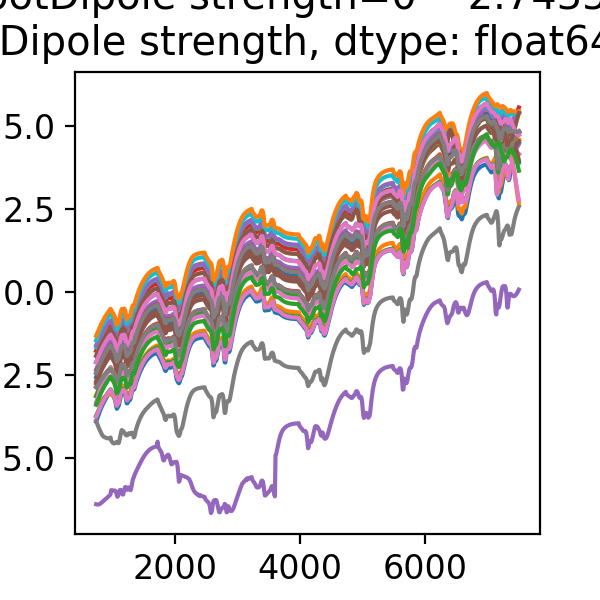

 24%|██▍       | 11/45 [00:00<00:00, 109.15it/s]

# Optimal param:	[ 1.05412545e-03 -3.42168248e+00]
# Sigma:	[7.67929871e-06 2.41377835e-01]
# Chi-square value: 	4212.771969954384
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
3
Loading Simulation data from disk .......
Loading hdf5 file
Activity profile data found!
Time step: 9.99609375
No:of particles : 32
No:of time points : 2560
Root path:  /home/deepak/ActiveFilamentsSearch_backup_3/ModellingResults/Analysis_test/SimResults_Np_32_Shape_line at angle_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point/IC_analysis/IC_34777/

3
Loading Simulation data from disk .......
Loading hdf5 file
Activity profile data found!
Time step: 9.997334044254865
No:of particles : 32
No:of time points : 3751
Root path:  /home/deepak/ActiveFilamentsSearch_backup_3/ModellingResults/Analysis_test/SimResults_Np_32_Shape_line at angle_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point/IC_analysis/IC_34777/IC_Sim_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point
Data file sim_data_00_filament_ic_002.hdf5
3
Loading Simulation data from disk .......
Loading hdf5 file
Activity profile data found!
Time step: 9.997334044254865
No:of particles : 32
No:of time points : 3751
Root path:  /home/deepak/ActiveFilamentsSearch_backup_3/ModellingResults/Analysis_test/SimResults_Np_32_Shape_line at angle_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point/IC_analysis/IC_34777/IC_Sim_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point
Dat

 69%|██████▉   | 31/45 [00:00<00:00, 55.47it/s] 

3
Loading Simulation data from disk .......
Loading hdf5 file
Activity profile data found!
Time step: 9.994900560938296
No:of particles : 32
No:of time points : 1961
Root path:  /home/deepak/ActiveFilamentsSearch_backup_3/ModellingResults/Analysis_test/SimResults_Np_32_Shape_line at angle_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point/IC_analysis/IC_34777/IC_Sim_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point
Data file sim_data_00_filament_ic_003.hdf5
3
Loading Simulation data from disk .......
Loading hdf5 file
Activity profile data found!
Time step: 9.989858012170385
No:of particles : 32
No:of time points : 986
Root path:  /home/deepak/ActiveFilamentsSearch_backup_3/ModellingResults/Analysis_test/SimResults_Np_32_Shape_line at angle_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point/IC_analysis/IC_34777/IC_Sim_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point
Data

3
Loading Simulation data from disk .......
Loading hdf5 file
Activity profile data found!
Time step: 9.997334044254865
No:of particles : 32
No:of time points : 3751
Root path:  /home/deepak/ActiveFilamentsSearch_backup_3/ModellingResults/Analysis_test/SimResults_Np_32_Shape_line at angle_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point/IC_analysis/IC_34777/IC_Sim_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point
Data file sim_data_00_filament_ic_001.hdf5
3
Loading Simulation data from disk .......
Loading hdf5 file
Activity profile data found!
Time step: 9.997334044254865
No:of particles : 32
No:of time points : 3751
Root path:  /home/deepak/ActiveFilamentsSearch_backup_3/ModellingResults/Analysis_test/SimResults_Np_32_Shape_line at angle_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point/IC_analysis/IC_34777/IC_Sim_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point
Dat

 87%|████████▋ | 39/45 [00:00<00:00, 34.93it/s]

3
Loading Simulation data from disk .......
Loading hdf5 file
Activity profile data found!
Time step: 9.997334044254865
No:of particles : 32
No:of time points : 3751
Root path:  /home/deepak/ActiveFilamentsSearch_backup_3/ModellingResults/Analysis_test/SimResults_Np_32_Shape_line at angle_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point/IC_analysis/IC_34777/IC_Sim_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point
Data file sim_data_00_filament_ic_007.hdf5
3
Loading Simulation data from disk .......
Loading hdf5 file
Activity profile data found!
Time step: 9.997334044254865
No:of particles : 32
No:of time points : 3751
Root path:  /home/deepak/ActiveFilamentsSearch_backup_3/ModellingResults/Analysis_test/SimResults_Np_32_Shape_line at angle_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point/IC_analysis/IC_34777/IC_Sim_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point
Dat

100%|██████████| 45/45 [00:01<00:00, 36.47it/s]

3
Loading Simulation data from disk .......
Loading hdf5 file
Activity profile data found!
Time step: 9.997334044254865
No:of particles : 32
No:of time points : 3751
Root path:  /home/deepak/ActiveFilamentsSearch_backup_3/ModellingResults/Analysis_test/SimResults_Np_32_Shape_line at angle_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point/IC_analysis/IC_34777/IC_Sim_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point
Data file sim_data_00_filament_ic_004.hdf5
3
Loading Simulation data from disk .......
Loading hdf5 file
Activity profile data found!
Time step: 9.997334044254865
No:of particles : 32
No:of time points : 3751
Root path:  /home/deepak/ActiveFilamentsSearch_backup_3/ModellingResults/Analysis_test/SimResults_Np_32_Shape_line at angle_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point/IC_analysis/IC_34777/IC_Sim_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point
Dat

<class 'numpy.int64'>
1
750
10.0


<IPython.core.display.Javascript object>


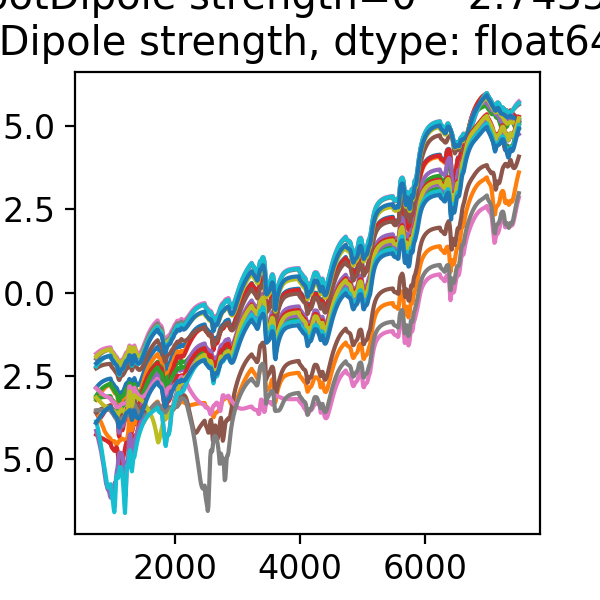

 22%|██▏       | 10/45 [00:00<00:00, 76.76it/s]

# Optimal param:	[ 1.26794396e-03 -5.03394303e+00]
# Sigma:	[3.62012766e-05 2.10292148e-01]
# Chi-square value: 	5189.099432000223
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
3
Loading Simulation data from disk .......
Loading hdf5 file
Activity profile data found!
Time step: 9.995717344753748
No:of particles : 32
No:of time points : 2335
Root path:  /home/deepak/ActiveFilamentsSearch_backup_3/ModellingResults/Analysis_test/SimResults_Np_32_Shape_line at angle_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point/IC_analysis/IC

3
Loading Simulation data from disk .......
Loading hdf5 file
Activity profile data found!
Time step: 9.997334044254865
No:of particles : 32
No:of time points : 3751
Root path:  /home/deepak/ActiveFilamentsSearch_backup_3/ModellingResults/Analysis_test/SimResults_Np_32_Shape_line at angle_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point/IC_analysis/IC_31927/IC_Sim_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point
Data file sim_data_00_filament_ic_002.hdf5
3
Loading Simulation data from disk .......
Loading hdf5 file
Activity profile data found!
Time step: 9.997334044254865
No:of particles : 32
No:of time points : 3751
Root path:  /home/deepak/ActiveFilamentsSearch_backup_3/ModellingResults/Analysis_test/SimResults_Np_32_Shape_line at angle_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point/IC_analysis/IC_31927/IC_Sim_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point
Dat

 51%|█████     | 23/45 [00:00<00:00, 38.56it/s]

3
Loading Simulation data from disk .......
Loading hdf5 file
Activity profile data found!
Time step: 9.997334044254865
No:of particles : 32
No:of time points : 3751
Root path:  /home/deepak/ActiveFilamentsSearch_backup_3/ModellingResults/Analysis_test/SimResults_Np_32_Shape_line at angle_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point/IC_analysis/IC_31927/IC_Sim_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point
Data file sim_data_00_filament_ic_003.hdf5
3
Loading Simulation data from disk .......
Loading hdf5 file
Activity profile data found!
Time step: 9.997334044254865
No:of particles : 32
No:of time points : 3751
Root path:  /home/deepak/ActiveFilamentsSearch_backup_3/ModellingResults/Analysis_test/SimResults_Np_32_Shape_line at angle_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point/IC_analysis/IC_31927/IC_Sim_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point
Dat

 73%|███████▎  | 33/45 [00:00<00:00, 40.12it/s]

3
Loading Simulation data from disk .......
Loading hdf5 file
Activity profile data found!
Time step: 9.997334044254865
No:of particles : 32
No:of time points : 3751
Root path:  /home/deepak/ActiveFilamentsSearch_backup_3/ModellingResults/Analysis_test/SimResults_Np_32_Shape_line at angle_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point/IC_analysis/IC_31927/IC_Sim_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point
Data file sim_data_00_filament_ic_009.hdf5
3
Loading Simulation data from disk .......
Loading hdf5 file
Activity profile data found!
Time step: 9.986842105263158
No:of particles : 32
No:of time points : 760
Root path:  /home/deepak/ActiveFilamentsSearch_backup_3/ModellingResults/Analysis_test/SimResults_Np_32_Shape_line at angle_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point/IC_analysis/IC_31927/IC_Sim_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point
Data

100%|██████████| 45/45 [00:00<00:00, 46.22it/s]


3
Loading Simulation data from disk .......
Loading hdf5 file
Activity profile data found!
Time step: 9.997334044254865
No:of particles : 32
No:of time points : 3751
Root path:  /home/deepak/ActiveFilamentsSearch_backup_3/ModellingResults/Analysis_test/SimResults_Np_32_Shape_line at angle_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point/IC_analysis/IC_31927/IC_Sim_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point
Data file sim_data_00_filament_ic_001.hdf5
3
Loading Simulation data from disk .......
Loading hdf5 file
Activity profile data found!
Time step: 9.995719178082192
No:of particles : 32
No:of time points : 2336
Root path:  /home/deepak/ActiveFilamentsSearch_backup_3/ModellingResults/Analysis_test/SimResults_Np_32_Shape_line at angle_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point/IC_analysis/IC_31927/IC_Sim_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point
Dat

<class 'numpy.int64'>
1
750
10.0


<IPython.core.display.Javascript object>


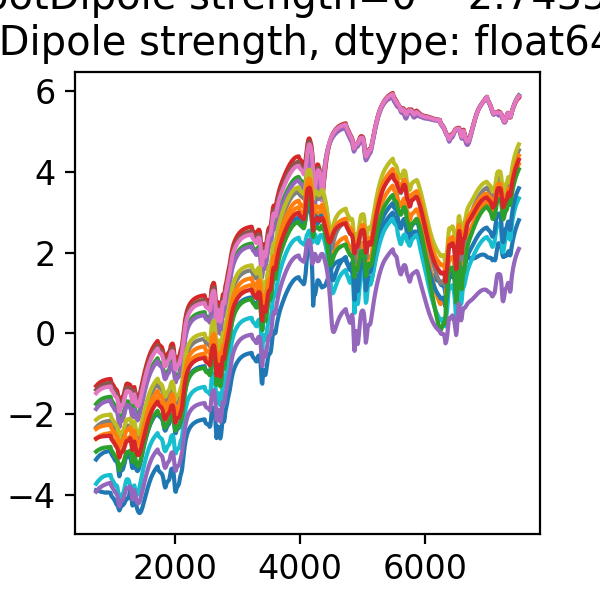

  4%|▍         | 2/45 [00:00<00:02, 16.12it/s]

# Optimal param:	[ 1.20701564e-03 -3.25059905e+00]
# Sigma:	[3.27430306e-05 1.95683123e-01]
# Chi-square value: 	8191.160924644222
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
3
Loading Simulation data from disk .......
Loading hdf5 file
Activity profile data found!
Time step: 9.997334044254865
No:of particles : 32
No:of time points : 3751
Root path:  /home/deepak/ActiveFilamentsSearch_backup_3/ModellingResults/Analysis_test/SimResults_Np_32_Shape_line at angle_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point/IC_analysis/IC

 16%|█▌        | 7/45 [00:00<00:02, 18.92it/s]

3
Loading Simulation data from disk .......
Loading hdf5 file
Activity profile data found!
Time step: 9.997334044254865
No:of particles : 32
No:of time points : 3751
Root path:  /home/deepak/ActiveFilamentsSearch_backup_3/ModellingResults/Analysis_test/SimResults_Np_32_Shape_line at angle_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point/IC_analysis/IC_34402/IC_Sim_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point
Data file sim_data_00_filament_ic_000.hdf5
3
Loading Simulation data from disk .......
Loading hdf5 file
Activity profile data found!
Time step: 9.997334044254865
No:of particles : 32
No:of time points : 3751
Root path:  /home/deepak/ActiveFilamentsSearch_backup_3/ModellingResults/Analysis_test/SimResults_Np_32_Shape_line at angle_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point/IC_analysis/IC_34402/IC_Sim_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point
Dat

 22%|██▏       | 10/45 [00:00<00:01, 22.20it/s]

3
Loading Simulation data from disk .......
Loading hdf5 file
Activity profile data found!
Time step: 9.997334044254865
No:of particles : 32
No:of time points : 3751
Root path:  /home/deepak/ActiveFilamentsSearch_backup_3/ModellingResults/Analysis_test/SimResults_Np_32_Shape_line at angle_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point/IC_analysis/IC_34402/IC_Sim_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point
Data file sim_data_00_filament_ic_008.hdf5
3
Loading Simulation data from disk .......
Loading hdf5 file
Activity profile data found!
Time step: 9.997334044254865
No:of particles : 32
No:of time points : 3751
Root path:  /home/deepak/ActiveFilamentsSearch_backup_3/ModellingResults/Analysis_test/SimResults_Np_32_Shape_line at angle_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point/IC_analysis/IC_34402/IC_Sim_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point
Dat

 29%|██▉       | 13/45 [00:00<00:01, 21.21it/s]

3
Loading Simulation data from disk .......
Loading hdf5 file
Activity profile data found!
Time step: 9.997334044254865
No:of particles : 32
No:of time points : 3751
Root path:  /home/deepak/ActiveFilamentsSearch_backup_3/ModellingResults/Analysis_test/SimResults_Np_32_Shape_line at angle_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point/IC_analysis/IC_34402/IC_Sim_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point
Data file sim_data_00_filament_ic_007.hdf5
3
Loading Simulation data from disk .......
Loading hdf5 file
Activity profile data found!
Time step: 9.997334044254865
No:of particles : 32
No:of time points : 3751
Root path:  /home/deepak/ActiveFilamentsSearch_backup_3/ModellingResults/Analysis_test/SimResults_Np_32_Shape_line at angle_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point/IC_analysis/IC_34402/IC_Sim_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point
Dat

 42%|████▏     | 19/45 [00:00<00:01, 21.95it/s]

3
Loading Simulation data from disk .......
Loading hdf5 file
Activity profile data found!
Time step: 9.997334044254865
No:of particles : 32
No:of time points : 3751
Root path:  /home/deepak/ActiveFilamentsSearch_backup_3/ModellingResults/Analysis_test/SimResults_Np_32_Shape_line at angle_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point/IC_analysis/IC_34402/IC_Sim_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point
Data file sim_data_00_filament_ic_002.hdf5
3
Loading Simulation data from disk .......
Loading hdf5 file
Activity profile data found!
Time step: 9.996978851963746
No:of particles : 32
No:of time points : 3310
Root path:  /home/deepak/ActiveFilamentsSearch_backup_3/ModellingResults/Analysis_test/SimResults_Np_32_Shape_line at angle_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point/IC_analysis/IC_34402/IC_Sim_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point
Dat

 56%|█████▌    | 25/45 [00:01<00:00, 23.24it/s]

3
Loading Simulation data from disk .......
Loading hdf5 file
Activity profile data found!
Time step: 9.997334044254865
No:of particles : 32
No:of time points : 3751
Root path:  /home/deepak/ActiveFilamentsSearch_backup_3/ModellingResults/Analysis_test/SimResults_Np_32_Shape_line at angle_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point/IC_analysis/IC_34402/IC_Sim_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point
Data file sim_data_00_filament_ic_003.hdf5
3
Loading Simulation data from disk .......
Loading hdf5 file
Activity profile data found!
Time step: 9.997334044254865
No:of particles : 32
No:of time points : 3751
Root path:  /home/deepak/ActiveFilamentsSearch_backup_3/ModellingResults/Analysis_test/SimResults_Np_32_Shape_line at angle_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point/IC_analysis/IC_34402/IC_Sim_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point
Dat

 62%|██████▏   | 28/45 [00:01<00:00, 22.22it/s]

Root path:  /home/deepak/ActiveFilamentsSearch_backup_3/ModellingResults/Analysis_test/SimResults_Np_32_Shape_line at angle_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point/IC_analysis/IC_34402/IC_Sim_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point
Data file sim_data_00_filament_ic_009.hdf5
3
Loading Simulation data from disk .......
Loading hdf5 file
Activity profile data found!
Time step: 9.997334044254865
No:of particles : 32
No:of time points : 3751
Root path:  /home/deepak/ActiveFilamentsSearch_backup_3/ModellingResults/Analysis_test/SimResults_Np_32_Shape_line at angle_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point/IC_analysis/IC_34402/IC_Sim_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point
Data file sim_data_00_filament_ic_006.hdf5
3
Loading Simulation data from disk .......
Loading hdf5 file
Activity profile data found!
Time step: 9.997334044254865
No:of 

 76%|███████▌  | 34/45 [00:01<00:00, 21.89it/s]

3
Loading Simulation data from disk .......
Loading hdf5 file
Activity profile data found!
Time step: 9.997334044254865
No:of particles : 32
No:of time points : 3751
Root path:  /home/deepak/ActiveFilamentsSearch_backup_3/ModellingResults/Analysis_test/SimResults_Np_32_Shape_line at angle_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point/IC_analysis/IC_34402/IC_Sim_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point
Data file sim_data_00_filament_ic_001.hdf5
3
Loading Simulation data from disk .......
Loading hdf5 file
Activity profile data found!
Time step: 9.997334044254865
No:of particles : 32
No:of time points : 3751
Root path:  /home/deepak/ActiveFilamentsSearch_backup_3/ModellingResults/Analysis_test/SimResults_Np_32_Shape_line at angle_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point/IC_analysis/IC_34402/IC_Sim_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point
Dat

 89%|████████▉ | 40/45 [00:01<00:00, 24.52it/s]

3
Loading Simulation data from disk .......
Loading hdf5 file
Activity profile data found!
Time step: 9.997334044254865
No:of particles : 32
No:of time points : 3751
Root path:  /home/deepak/ActiveFilamentsSearch_backup_3/ModellingResults/Analysis_test/SimResults_Np_32_Shape_line at angle_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point/IC_analysis/IC_34402/IC_Sim_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point
Data file sim_data_00_filament_ic_007.hdf5
3
Loading Simulation data from disk .......
Loading hdf5 file
Activity profile data found!
Time step: 9.997334044254865
No:of particles : 32
No:of time points : 3751
Root path:  /home/deepak/ActiveFilamentsSearch_backup_3/ModellingResults/Analysis_test/SimResults_Np_32_Shape_line at angle_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point/IC_analysis/IC_34402/IC_Sim_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point
Dat

100%|██████████| 45/45 [00:01<00:00, 23.25it/s]


3
Loading Simulation data from disk .......
Loading hdf5 file
Activity profile data found!
Time step: 9.997334044254865
No:of particles : 32
No:of time points : 3751
Root path:  /home/deepak/ActiveFilamentsSearch_backup_3/ModellingResults/Analysis_test/SimResults_Np_32_Shape_line at angle_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point/IC_analysis/IC_34402/IC_Sim_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point
Data file sim_data_00_filament_ic_006.hdf5
3
Loading Simulation data from disk .......
Loading hdf5 file
Activity profile data found!
Time step: 9.996978851963746
No:of particles : 32
No:of time points : 3310
Root path:  /home/deepak/ActiveFilamentsSearch_backup_3/ModellingResults/Analysis_test/SimResults_Np_32_Shape_line at angle_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point/IC_analysis/IC_34402/IC_Sim_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point
Dat

<IPython.core.display.Javascript object>


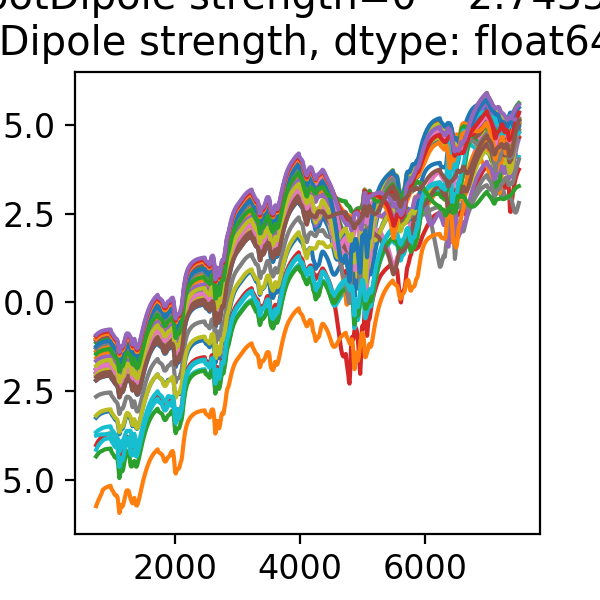

 22%|██▏       | 10/45 [00:00<00:00, 79.36it/s]

# Optimal param:	[ 1.02266932e-03 -2.68981379e+00]
# Sigma:	[3.66482245e-05 2.67527857e-01]
# Chi-square value: 	9836.808986949436
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
3
Loading Simulation data from disk .......
Loading hdf5 file
Activity profile data found!
Time step: 9.991776315789474
No:of particles : 32
No:of time points : 1216
Root path:  /home/deepak/ActiveFilamentsSearch_backup_3/ModellingResults/Analysis_test/SimResults_Np_32_Shape_line at angle_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point/IC_analysis/IC

3
Loading Simulation data from disk .......
Loading hdf5 file
Activity profile data found!
Time step: 9.997334044254865
No:of particles : 32
No:of time points : 3751
Root path:  /home/deepak/ActiveFilamentsSearch_backup_3/ModellingResults/Analysis_test/SimResults_Np_32_Shape_line at angle_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point/IC_analysis/IC_31402/IC_Sim_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point
Data file sim_data_00_filament_ic_002.hdf5
3
Loading Simulation data from disk .......
Loading hdf5 file
Activity profile data found!
Time step: 9.997334044254865
No:of particles : 32
No:of time points : 3751
Root path:  /home/deepak/ActiveFilamentsSearch_backup_3/ModellingResults/Analysis_test/SimResults_Np_32_Shape_line at angle_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point/IC_analysis/IC_31402/IC_Sim_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point
Dat

 51%|█████     | 23/45 [00:00<00:00, 35.49it/s]

3
Loading Simulation data from disk .......
Loading hdf5 file
Activity profile data found!
Time step: 9.997334044254865
No:of particles : 32
No:of time points : 3751
Root path:  /home/deepak/ActiveFilamentsSearch_backup_3/ModellingResults/Analysis_test/SimResults_Np_32_Shape_line at angle_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point/IC_analysis/IC_31402/IC_Sim_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point
Data file sim_data_00_filament_ic_003.hdf5
3
Loading Simulation data from disk .......
Loading hdf5 file
Activity profile data found!
Time step: 9.997334044254865
No:of particles : 32
No:of time points : 3751
Root path:  /home/deepak/ActiveFilamentsSearch_backup_3/ModellingResults/Analysis_test/SimResults_Np_32_Shape_line at angle_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point/IC_analysis/IC_31402/IC_Sim_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point
Dat

 60%|██████    | 27/45 [00:00<00:00, 29.54it/s]

3
Loading Simulation data from disk .......
Loading hdf5 file
Activity profile data found!
Time step: 9.997334044254865
No:of particles : 32
No:of time points : 3751
Root path:  /home/deepak/ActiveFilamentsSearch_backup_3/ModellingResults/Analysis_test/SimResults_Np_32_Shape_line at angle_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point/IC_analysis/IC_31402/IC_Sim_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point
Data file sim_data_00_filament_ic_009.hdf5
3
Loading Simulation data from disk .......
Loading hdf5 file
Activity profile data found!
Time step: 9.997334044254865
No:of particles : 32
No:of time points : 3751
Root path:  /home/deepak/ActiveFilamentsSearch_backup_3/ModellingResults/Analysis_test/SimResults_Np_32_Shape_line at angle_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point/IC_analysis/IC_31402/IC_Sim_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point
Dat

100%|██████████| 45/45 [00:01<00:00, 41.64it/s]

3
Loading Simulation data from disk .......
Loading hdf5 file
Activity profile data found!
Time step: 9.997334044254865
No:of particles : 32
No:of time points : 3751
Root path:  /home/deepak/ActiveFilamentsSearch_backup_3/ModellingResults/Analysis_test/SimResults_Np_32_Shape_line at angle_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point/IC_analysis/IC_31402/IC_Sim_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point
Data file sim_data_00_filament_ic_001.hdf5
3
Loading Simulation data from disk .......
Loading hdf5 file
Activity profile data found!
Time step: 9.997334044254865
No:of particles : 32
No:of time points : 3751
Root path:  /home/deepak/ActiveFilamentsSearch_backup_3/ModellingResults/Analysis_test/SimResults_Np_32_Shape_line at angle_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point/IC_analysis/IC_31402/IC_Sim_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point
Dat

<class 'numpy.int64'>
1
750
10.0


<IPython.core.display.Javascript object>


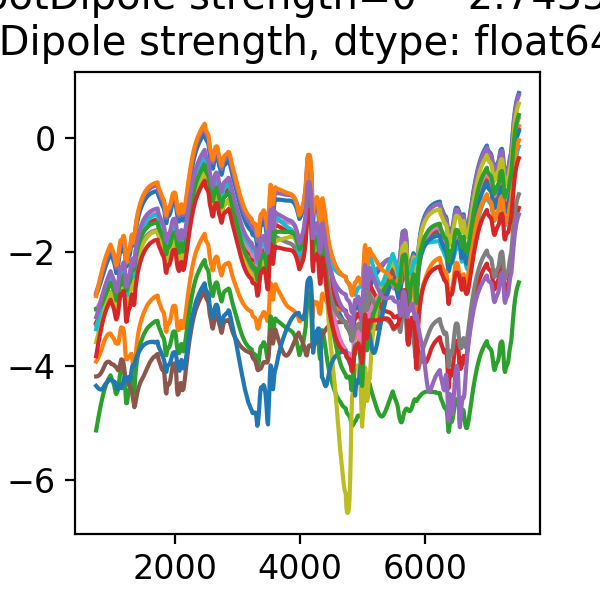

 20%|██        | 9/45 [00:00<00:00, 87.85it/s]

# Optimal param:	[ 2.85730053e-05 -2.52576355e+00]
# Sigma:	[5.36363552e-05 3.15520848e-01]
# Chi-square value: 	6528.067376150362
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
3
Loading Simulation data from disk .......
Loading hdf5 file
Activity profile data found!
Time step: 9.994249568717654
No:of particles : 32
No:of time points : 1739
Root path:  /home/deepak/ActiveFilamentsSearch_backup_3/ModellingResults/Analysis_test/SimResults_Np_32_Shape_line at angle_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point/IC_analysis/IC

3
Loading Simulation data from disk .......
Loading hdf5 file
Activity profile data found!
Time step: 9.997334044254865
No:of particles : 32
No:of time points : 3751
Root path:  /home/deepak/ActiveFilamentsSearch_backup_3/ModellingResults/Analysis_test/SimResults_Np_32_Shape_line at angle_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point/IC_analysis/IC_36502/IC_Sim_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point
Data file sim_data_00_filament_ic_002.hdf5
3
Loading Simulation data from disk .......
Loading hdf5 file
Activity profile data found!
Time step: 9.997334044254865
No:of particles : 32
No:of time points : 3751
Root path:  /home/deepak/ActiveFilamentsSearch_backup_3/ModellingResults/Analysis_test/SimResults_Np_32_Shape_line at angle_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point/IC_analysis/IC_36502/IC_Sim_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point
Dat

 40%|████      | 18/45 [00:00<00:00, 31.19it/s]

3
Loading Simulation data from disk .......
Loading hdf5 file
Activity profile data found!
Time step: 9.997334044254865
No:of particles : 32
No:of time points : 3751
Root path:  /home/deepak/ActiveFilamentsSearch_backup_3/ModellingResults/Analysis_test/SimResults_Np_32_Shape_line at angle_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point/IC_analysis/IC_36502/IC_Sim_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point
Data file sim_data_00_filament_ic_002.hdf5
3
Loading Simulation data from disk .......
Loading hdf5 file
Activity profile data found!
Time step: 9.997334044254865
No:of particles : 32
No:of time points : 3751
Root path:  /home/deepak/ActiveFilamentsSearch_backup_3/ModellingResults/Analysis_test/SimResults_Np_32_Shape_line at angle_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point/IC_analysis/IC_36502/IC_Sim_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point
Dat

 51%|█████     | 23/45 [00:00<00:00, 28.72it/s]

3
Loading Simulation data from disk .......
Loading hdf5 file
Activity profile data found!
Time step: 9.997334044254865
No:of particles : 32
No:of time points : 3751
Root path:  /home/deepak/ActiveFilamentsSearch_backup_3/ModellingResults/Analysis_test/SimResults_Np_32_Shape_line at angle_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point/IC_analysis/IC_36502/IC_Sim_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point
Data file sim_data_00_filament_ic_003.hdf5
3
Loading Simulation data from disk .......
Loading hdf5 file
Activity profile data found!
Time step: 9.99398677089597
No:of particles : 32
No:of time points : 1663
Root path:  /home/deepak/ActiveFilamentsSearch_backup_3/ModellingResults/Analysis_test/SimResults_Np_32_Shape_line at angle_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point/IC_analysis/IC_36502/IC_Sim_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point
Data

 60%|██████    | 27/45 [00:00<00:00, 27.63it/s]

Root path:  /home/deepak/ActiveFilamentsSearch_backup_3/ModellingResults/Analysis_test/SimResults_Np_32_Shape_line at angle_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point/IC_analysis/IC_36502/IC_Sim_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point
Data file sim_data_00_filament_ic_007.hdf5
3
Loading Simulation data from disk .......
Loading hdf5 file
Activity profile data found!
Time step: 9.997334044254865
No:of particles : 32
No:of time points : 3751
Root path:  /home/deepak/ActiveFilamentsSearch_backup_3/ModellingResults/Analysis_test/SimResults_Np_32_Shape_line at angle_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point/IC_analysis/IC_36502/IC_Sim_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point
Data file sim_data_00_filament_ic_009.hdf5
3
Loading Simulation data from disk .......
Loading hdf5 file
Activity profile data found!
Time step: 9.99398677089597
No:of p

 76%|███████▌  | 34/45 [00:01<00:00, 25.95it/s]

3
Loading Simulation data from disk .......
Loading hdf5 file
Activity profile data found!
Time step: 9.997334044254865
No:of particles : 32
No:of time points : 3751
Root path:  /home/deepak/ActiveFilamentsSearch_backup_3/ModellingResults/Analysis_test/SimResults_Np_32_Shape_line at angle_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point/IC_analysis/IC_36502/IC_Sim_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point
Data file sim_data_00_filament_ic_001.hdf5
3
Loading Simulation data from disk .......
Loading hdf5 file
Activity profile data found!
Time step: 9.99398677089597
No:of particles : 32
No:of time points : 1663
Root path:  /home/deepak/ActiveFilamentsSearch_backup_3/ModellingResults/Analysis_test/SimResults_Np_32_Shape_line at angle_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point/IC_analysis/IC_36502/IC_Sim_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point
Data

 89%|████████▉ | 40/45 [00:01<00:00, 26.16it/s]

3
Loading Simulation data from disk .......
Loading hdf5 file
Activity profile data found!
Time step: 9.997334044254865
No:of particles : 32
No:of time points : 3751
Root path:  /home/deepak/ActiveFilamentsSearch_backup_3/ModellingResults/Analysis_test/SimResults_Np_32_Shape_line at angle_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point/IC_analysis/IC_36502/IC_Sim_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point
Data file sim_data_00_filament_ic_007.hdf5
3
Loading Simulation data from disk .......
Loading hdf5 file
Activity profile data found!
Time step: 9.997334044254865
No:of particles : 32
No:of time points : 3751
Root path:  /home/deepak/ActiveFilamentsSearch_backup_3/ModellingResults/Analysis_test/SimResults_Np_32_Shape_line at angle_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point/IC_analysis/IC_36502/IC_Sim_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point
Dat

100%|██████████| 45/45 [00:01<00:00, 28.32it/s]


3
Loading Simulation data from disk .......
Loading hdf5 file
Activity profile data found!
Time step: 9.997334044254865
No:of particles : 32
No:of time points : 3751
Root path:  /home/deepak/ActiveFilamentsSearch_backup_3/ModellingResults/Analysis_test/SimResults_Np_32_Shape_line at angle_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point/IC_analysis/IC_36502/IC_Sim_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point
Data file sim_data_00_filament_ic_008.hdf5
3
Loading Simulation data from disk .......
Loading hdf5 file
Activity profile data found!
Time step: 9.997334044254865
No:of particles : 32
No:of time points : 3751
Root path:  /home/deepak/ActiveFilamentsSearch_backup_3/ModellingResults/Analysis_test/SimResults_Np_32_Shape_line at angle_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point/IC_analysis/IC_36502/IC_Sim_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point
Dat

<IPython.core.display.Javascript object>


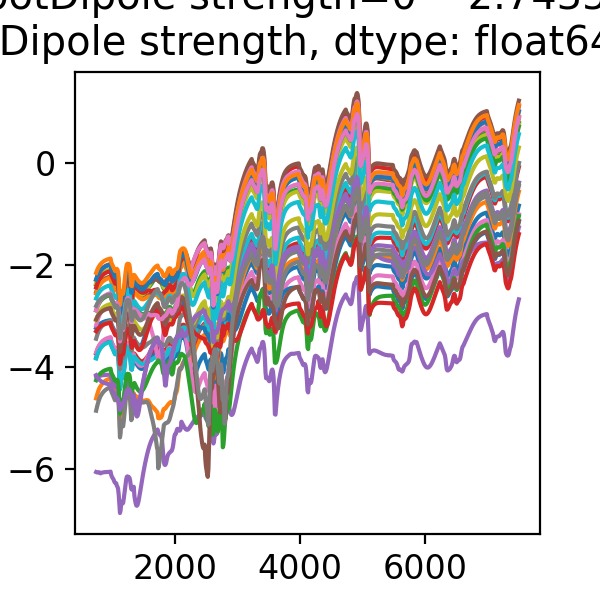

  7%|▋         | 3/45 [00:00<00:01, 28.48it/s]

# Optimal param:	[ 4.72671091e-04 -3.77258697e+00]
# Sigma:	[1.94660524e-05 1.65756318e-01]
# Chi-square value: 	4891.9717080911305
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
3
Loading Simulation data from disk .......
Loading hdf5 file
Activity profile data found!
Time step: 9.997334044254865
No:of particles : 32
No:of time points : 3751
Root path:  /home/deepak/ActiveFilamentsSearch_backup_3/ModellingResults/Analysis_test/SimResults_Np_32_Shape_line at angle_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point/IC_analysis/I

 29%|██▉       | 13/45 [00:00<00:00, 44.95it/s]

3
Loading Simulation data from disk .......
Loading hdf5 file
Activity profile data found!
Time step: 9.997334044254865
No:of particles : 32
No:of time points : 3751
Root path:  /home/deepak/ActiveFilamentsSearch_backup_3/ModellingResults/Analysis_test/SimResults_Np_32_Shape_line at angle_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point/IC_analysis/IC_30727/IC_Sim_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point
Data file sim_data_00_filament_ic_000.hdf5
3
Loading Simulation data from disk .......
Loading hdf5 file
Activity profile data found!
Time step: 9.997334044254865
No:of particles : 32
No:of time points : 3751
Root path:  /home/deepak/ActiveFilamentsSearch_backup_3/ModellingResults/Analysis_test/SimResults_Np_32_Shape_line at angle_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point/IC_analysis/IC_30727/IC_Sim_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point
Dat

 42%|████▏     | 19/45 [00:00<00:00, 49.83it/s]

3
Loading Simulation data from disk .......
Loading hdf5 file
Activity profile data found!
Time step: 9.997334044254865
No:of particles : 32
No:of time points : 3751
Root path:  /home/deepak/ActiveFilamentsSearch_backup_3/ModellingResults/Analysis_test/SimResults_Np_32_Shape_line at angle_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point/IC_analysis/IC_30727/IC_Sim_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point
Data file sim_data_00_filament_ic_009.hdf5
3
Loading Simulation data from disk .......
Loading hdf5 file
Activity profile data found!
Time step: 9.997334044254865
No:of particles : 32
No:of time points : 3751
Root path:  /home/deepak/ActiveFilamentsSearch_backup_3/ModellingResults/Analysis_test/SimResults_Np_32_Shape_line at angle_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point/IC_analysis/IC_30727/IC_Sim_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point
Dat

 56%|█████▌    | 25/45 [00:00<00:00, 40.99it/s]

3
Loading Simulation data from disk .......
Loading hdf5 file
Activity profile data found!
Time step: 9.997334044254865
No:of particles : 32
No:of time points : 3751
Root path:  /home/deepak/ActiveFilamentsSearch_backup_3/ModellingResults/Analysis_test/SimResults_Np_32_Shape_line at angle_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point/IC_analysis/IC_30727/IC_Sim_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point
Data file sim_data_00_filament_ic_003.hdf5
3
Loading Simulation data from disk .......
Loading hdf5 file
Activity profile data found!
Time step: 9.995429616087751
No:of particles : 32
No:of time points : 2188
Root path:  /home/deepak/ActiveFilamentsSearch_backup_3/ModellingResults/Analysis_test/SimResults_Np_32_Shape_line at angle_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point/IC_analysis/IC_30727/IC_Sim_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point
Dat

 82%|████████▏ | 37/45 [00:00<00:00, 39.55it/s]

3
Loading Simulation data from disk .......
Loading hdf5 file
Activity profile data found!
Time step: 9.993690851735016
No:of particles : 32
No:of time points : 1585
Root path:  /home/deepak/ActiveFilamentsSearch_backup_3/ModellingResults/Analysis_test/SimResults_Np_32_Shape_line at angle_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point/IC_analysis/IC_30727/IC_Sim_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point
Data file sim_data_00_filament_ic_005.hdf5
3
Loading Simulation data from disk .......
Loading hdf5 file
Activity profile data found!
Time step: 9.994714587737844
No:of particles : 32
No:of time points : 1892
Root path:  /home/deepak/ActiveFilamentsSearch_backup_3/ModellingResults/Analysis_test/SimResults_Np_32_Shape_line at angle_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point/IC_analysis/IC_30727/IC_Sim_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point
Dat

100%|██████████| 45/45 [00:01<00:00, 42.81it/s]


3
Loading Simulation data from disk .......
Loading hdf5 file
Activity profile data found!
Time step: 9.997334044254865
No:of particles : 32
No:of time points : 3751
Root path:  /home/deepak/ActiveFilamentsSearch_backup_3/ModellingResults/Analysis_test/SimResults_Np_32_Shape_line at angle_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point/IC_analysis/IC_30727/IC_Sim_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point
Data file sim_data_00_filament_ic_006.hdf5
3
Loading Simulation data from disk .......
Loading hdf5 file
Activity profile data found!
Time step: 9.995429616087751
No:of particles : 32
No:of time points : 2188
Root path:  /home/deepak/ActiveFilamentsSearch_backup_3/ModellingResults/Analysis_test/SimResults_Np_32_Shape_line at angle_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point/IC_analysis/IC_30727/IC_Sim_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point
Dat

<IPython.core.display.Javascript object>


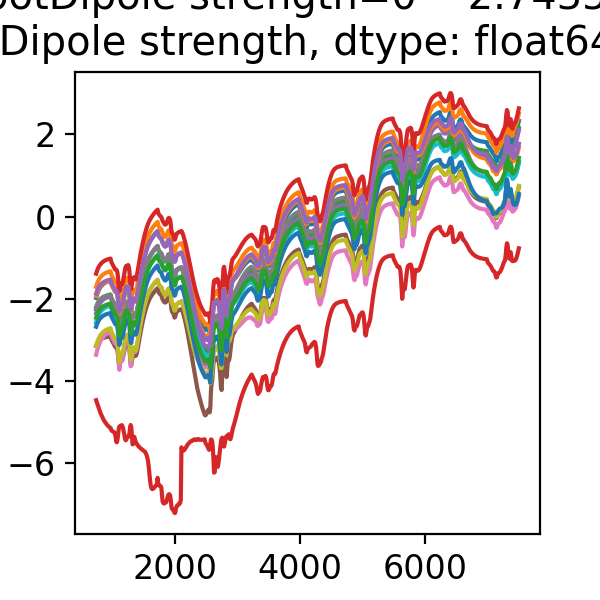

  4%|▍         | 2/45 [00:00<00:02, 15.54it/s]

# Optimal param:	[ 7.58948892e-04 -3.79882170e+00]
# Sigma:	[1.45001705e-05 2.64198477e-01]
# Chi-square value: 	5382.426745379363
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
3
Loading Simulation data from disk .......
Loading hdf5 file
Activity profile data found!
Time step: 9.997334044254865
No:of particles : 32
No:of time points : 3751
Root path:  /home/deepak/ActiveFilamentsSearch_backup_3/ModellingResults/Analysis_test/SimResults_Np_32_Shape_line at angle_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point/IC_analysis/IC

 16%|█▌        | 7/45 [00:00<00:01, 21.41it/s]

3
Loading Simulation data from disk .......
Loading hdf5 file
Activity profile data found!
Time step: 9.997334044254865
No:of particles : 32
No:of time points : 3751
Root path:  /home/deepak/ActiveFilamentsSearch_backup_3/ModellingResults/Analysis_test/SimResults_Np_32_Shape_line at angle_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point/IC_analysis/IC_37327/IC_Sim_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point
Data file sim_data_00_filament_ic_000.hdf5
3
Loading Simulation data from disk .......
Loading hdf5 file
Activity profile data found!
Time step: 9.997334044254865
No:of particles : 32
No:of time points : 3751
Root path:  /home/deepak/ActiveFilamentsSearch_backup_3/ModellingResults/Analysis_test/SimResults_Np_32_Shape_line at angle_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point/IC_analysis/IC_37327/IC_Sim_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point
Dat

 22%|██▏       | 10/45 [00:00<00:01, 20.25it/s]

3
Loading Simulation data from disk .......
Loading hdf5 file
Activity profile data found!
Time step: 9.997334044254865
No:of particles : 32
No:of time points : 3751
Root path:  /home/deepak/ActiveFilamentsSearch_backup_3/ModellingResults/Analysis_test/SimResults_Np_32_Shape_line at angle_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point/IC_analysis/IC_37327/IC_Sim_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point
Data file sim_data_00_filament_ic_000.hdf5
3
Loading Simulation data from disk .......
Loading hdf5 file
Activity profile data found!
Time step: 9.997334044254865
No:of particles : 32
No:of time points : 3751
Root path:  /home/deepak/ActiveFilamentsSearch_backup_3/ModellingResults/Analysis_test/SimResults_Np_32_Shape_line at angle_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point/IC_analysis/IC_37327/IC_Sim_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point
Dat

 36%|███▌      | 16/45 [00:00<00:01, 22.47it/s]

Root path:  /home/deepak/ActiveFilamentsSearch_backup_3/ModellingResults/Analysis_test/SimResults_Np_32_Shape_line at angle_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point/IC_analysis/IC_37327/IC_Sim_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point
Data file sim_data_00_filament_ic_002.hdf5
3
Loading Simulation data from disk .......
Loading hdf5 file
Activity profile data found!
Time step: 9.997334044254865
No:of particles : 32
No:of time points : 3751
Root path:  /home/deepak/ActiveFilamentsSearch_backup_3/ModellingResults/Analysis_test/SimResults_Np_32_Shape_line at angle_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point/IC_analysis/IC_37327/IC_Sim_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point
Data file sim_data_00_filament_ic_007.hdf5
3
Loading Simulation data from disk .......
Loading hdf5 file
Activity profile data found!
Time step: 9.997334044254865
No:of 

 42%|████▏     | 19/45 [00:00<00:01, 21.58it/s]

3
Loading Simulation data from disk .......
Loading hdf5 file
Activity profile data found!
Time step: 9.997334044254865
No:of particles : 32
No:of time points : 3751
Root path:  /home/deepak/ActiveFilamentsSearch_backup_3/ModellingResults/Analysis_test/SimResults_Np_32_Shape_line at angle_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point/IC_analysis/IC_37327/IC_Sim_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point
Data file sim_data_00_filament_ic_003.hdf5
3
Loading Simulation data from disk .......
Loading hdf5 file
Activity profile data found!
Time step: 9.997334044254865
No:of particles : 32
No:of time points : 3751
Root path:  /home/deepak/ActiveFilamentsSearch_backup_3/ModellingResults/Analysis_test/SimResults_Np_32_Shape_line at angle_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point/IC_analysis/IC_37327/IC_Sim_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point
Dat

 56%|█████▌    | 25/45 [00:01<00:00, 22.00it/s]

3
Loading Simulation data from disk .......
Loading hdf5 file
Activity profile data found!
Time step: 9.997334044254865
No:of particles : 32
No:of time points : 3751
Root path:  /home/deepak/ActiveFilamentsSearch_backup_3/ModellingResults/Analysis_test/SimResults_Np_32_Shape_line at angle_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point/IC_analysis/IC_37327/IC_Sim_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point
Data file sim_data_00_filament_ic_003.hdf5
3
Loading Simulation data from disk .......
Loading hdf5 file
Activity profile data found!
Time step: 9.997334044254865
No:of particles : 32
No:of time points : 3751
Root path:  /home/deepak/ActiveFilamentsSearch_backup_3/ModellingResults/Analysis_test/SimResults_Np_32_Shape_line at angle_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point/IC_analysis/IC_37327/IC_Sim_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point
Dat

 62%|██████▏   | 28/45 [00:01<00:00, 23.30it/s]

3
Loading Simulation data from disk .......
Loading hdf5 file
Activity profile data found!
Time step: 9.997334044254865
No:of particles : 32
No:of time points : 3751
Root path:  /home/deepak/ActiveFilamentsSearch_backup_3/ModellingResults/Analysis_test/SimResults_Np_32_Shape_line at angle_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point/IC_analysis/IC_37327/IC_Sim_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point
Data file sim_data_00_filament_ic_009.hdf5
3
Loading Simulation data from disk .......
Loading hdf5 file
Activity profile data found!
Time step: 9.992223950233281
No:of particles : 32
No:of time points : 1286
Root path:  /home/deepak/ActiveFilamentsSearch_backup_3/ModellingResults/Analysis_test/SimResults_Np_32_Shape_line at angle_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point/IC_analysis/IC_37327/IC_Sim_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point
Dat

 76%|███████▌  | 34/45 [00:01<00:00, 22.78it/s]

3
Loading Simulation data from disk .......
Loading hdf5 file
Activity profile data found!
Time step: 9.997334044254865
No:of particles : 32
No:of time points : 3751
Root path:  /home/deepak/ActiveFilamentsSearch_backup_3/ModellingResults/Analysis_test/SimResults_Np_32_Shape_line at angle_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point/IC_analysis/IC_37327/IC_Sim_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point
Data file sim_data_00_filament_ic_001.hdf5
3
Loading Simulation data from disk .......
Loading hdf5 file
Activity profile data found!
Time step: 9.992223950233281
No:of particles : 32
No:of time points : 1286
Root path:  /home/deepak/ActiveFilamentsSearch_backup_3/ModellingResults/Analysis_test/SimResults_Np_32_Shape_line at angle_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point/IC_analysis/IC_37327/IC_Sim_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point
Dat

 89%|████████▉ | 40/45 [00:01<00:00, 24.28it/s]

3
Loading Simulation data from disk .......
Loading hdf5 file
Activity profile data found!
Time step: 9.997334044254865
No:of particles : 32
No:of time points : 3751
Root path:  /home/deepak/ActiveFilamentsSearch_backup_3/ModellingResults/Analysis_test/SimResults_Np_32_Shape_line at angle_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point/IC_analysis/IC_37327/IC_Sim_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point
Data file sim_data_00_filament_ic_007.hdf5
3
Loading Simulation data from disk .......
Loading hdf5 file
Activity profile data found!
Time step: 9.997334044254865
No:of particles : 32
No:of time points : 3751
Root path:  /home/deepak/ActiveFilamentsSearch_backup_3/ModellingResults/Analysis_test/SimResults_Np_32_Shape_line at angle_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point/IC_analysis/IC_37327/IC_Sim_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point
Dat

100%|██████████| 45/45 [00:01<00:00, 22.78it/s]


3
Loading Simulation data from disk .......
Loading hdf5 file
Activity profile data found!
Time step: 9.997334044254865
No:of particles : 32
No:of time points : 3751
Root path:  /home/deepak/ActiveFilamentsSearch_backup_3/ModellingResults/Analysis_test/SimResults_Np_32_Shape_line at angle_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point/IC_analysis/IC_37327/IC_Sim_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point
Data file sim_data_00_filament_ic_008.hdf5
3
Loading Simulation data from disk .......
Loading hdf5 file
Activity profile data found!
Time step: 9.997334044254865
No:of particles : 32
No:of time points : 3751
Root path:  /home/deepak/ActiveFilamentsSearch_backup_3/ModellingResults/Analysis_test/SimResults_Np_32_Shape_line at angle_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point/IC_analysis/IC_37327/IC_Sim_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point
Dat

<IPython.core.display.Javascript object>


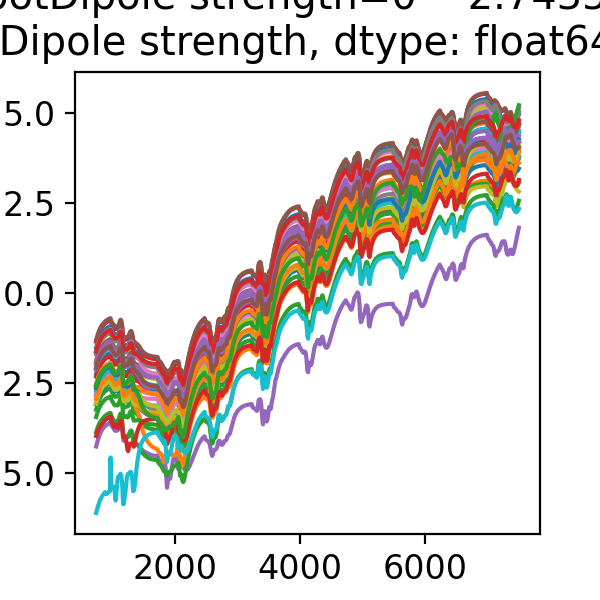

  9%|▉         | 4/45 [00:00<00:01, 35.43it/s]

# Optimal param:	[ 1.28921458e-03 -4.70386285e+00]
# Sigma:	[8.49246230e-06 1.29527211e-01]
# Chi-square value: 	15166.108084066105
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
3
Loading Simulation data from disk .......
Loading hdf5 file
Activity profile data found!
Time step: 9.997334044254865
No:of particles : 32
No:of time points : 3751
Root path:  /home/deepak/ActiveFilamentsSearch_backup_3/ModellingResults/Analysis_test/SimResults_Np_32_Shape_line at angle_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point/IC_analysis/I

 18%|█▊        | 8/45 [00:00<00:01, 28.21it/s]

3
Loading Simulation data from disk .......
Loading hdf5 file
Activity profile data found!
Time step: 9.997334044254865
No:of particles : 32
No:of time points : 3751
Root path:  /home/deepak/ActiveFilamentsSearch_backup_3/ModellingResults/Analysis_test/SimResults_Np_32_Shape_line at angle_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point/IC_analysis/IC_31252/IC_Sim_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point
Data file sim_data_00_filament_ic_000.hdf5
3
Loading Simulation data from disk .......
Loading hdf5 file
Activity profile data found!
Time step: 9.997334044254865
No:of particles : 32
No:of time points : 3751
Root path:  /home/deepak/ActiveFilamentsSearch_backup_3/ModellingResults/Analysis_test/SimResults_Np_32_Shape_line at angle_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point/IC_analysis/IC_31252/IC_Sim_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point
Dat

 44%|████▍     | 20/45 [00:00<00:00, 62.13it/s]

Root path:  /home/deepak/ActiveFilamentsSearch_backup_3/ModellingResults/Analysis_test/SimResults_Np_32_Shape_line at angle_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point/IC_analysis/IC_31252/IC_Sim_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point
Data file sim_data_00_filament_ic_007.hdf5
3
Loading Simulation data from disk .......
Loading hdf5 file
Activity profile data found!
Time step: 9.996095275283093
No:of particles : 32
No:of time points : 2561
Root path:  /home/deepak/ActiveFilamentsSearch_backup_3/ModellingResults/Analysis_test/SimResults_Np_32_Shape_line at angle_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point/IC_analysis/IC_31252/IC_Sim_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point
Data file sim_data_00_filament_ic_003.hdf5
3
Loading Simulation data from disk .......
Loading hdf5 file
Activity profile data found!
Time step: 9.997334044254865
No:of 

 76%|███████▌  | 34/45 [00:00<00:00, 42.03it/s]

3
Loading Simulation data from disk .......
Loading hdf5 file
Activity profile data found!
Time step: 9.997334044254865
No:of particles : 32
No:of time points : 3751
Root path:  /home/deepak/ActiveFilamentsSearch_backup_3/ModellingResults/Analysis_test/SimResults_Np_32_Shape_line at angle_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point/IC_analysis/IC_31252/IC_Sim_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point
Data file sim_data_00_filament_ic_009.hdf5
3
Loading Simulation data from disk .......
Loading hdf5 file
Activity profile data found!
Time step: 9.997229916897506
No:of particles : 32
No:of time points : 3610
Root path:  /home/deepak/ActiveFilamentsSearch_backup_3/ModellingResults/Analysis_test/SimResults_Np_32_Shape_line at angle_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point/IC_analysis/IC_31252/IC_Sim_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point
Dat

100%|██████████| 45/45 [00:01<00:00, 44.83it/s]

3
Loading Simulation data from disk .......
Loading hdf5 file
Activity profile data found!
Time step: 9.997334044254865
No:of particles : 32
No:of time points : 3751
Root path:  /home/deepak/ActiveFilamentsSearch_backup_3/ModellingResults/Analysis_test/SimResults_Np_32_Shape_line at angle_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point/IC_analysis/IC_31252/IC_Sim_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point
Data file sim_data_00_filament_ic_007.hdf5
3
Loading Simulation data from disk .......
Loading hdf5 file
Activity profile data found!
Time step: 9.997334044254865
No:of particles : 32
No:of time points : 3751
Root path:  /home/deepak/ActiveFilamentsSearch_backup_3/ModellingResults/Analysis_test/SimResults_Np_32_Shape_line at angle_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point/IC_analysis/IC_31252/IC_Sim_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point
Dat

<class 'numpy.int64'>
1
750
10.0


<IPython.core.display.Javascript object>


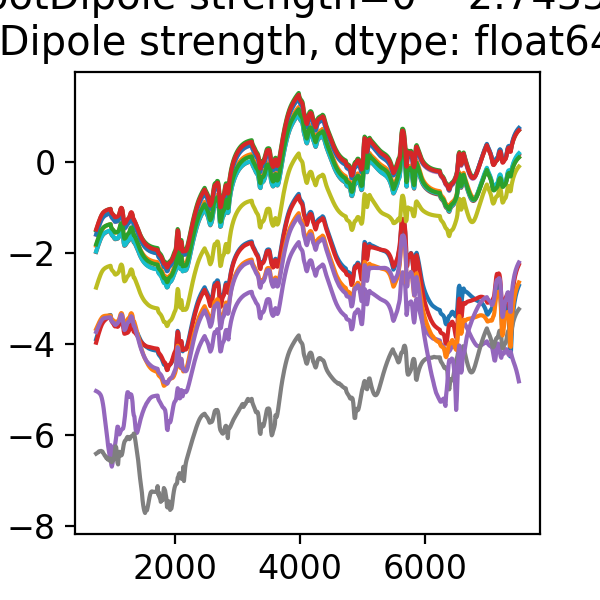

 20%|██        | 9/45 [00:00<00:00, 89.53it/s]

# Optimal param:	[ 2.60942080e-04 -2.79888648e+00]
# Sigma:	[2.32969595e-05 4.16439824e-01]
# Chi-square value: 	2093.278080293897
**************************************************
Loading IC simulation files...
['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_002.hdf5', 'sim_data_00_filament_ic_003.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_001.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_008.hdf5', 'sim_data_00_filament_ic_005.hdf5']
**************************************************
3
Loading Simulation data from disk .......
Loading hdf5 file
Activity profile data found!
Time step: 9.997112330349408
No:of particles : 32
No:of time points : 3463
Root path:  /home/deepak/ActiveFilamentsSearch_backup_3/ModellingResults/Analysis_test/SimResults_Np_32_Shape_line at angle_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point/IC_analysis/IC

3
Loading Simulation data from disk .......
Loading hdf5 file
Activity profile data found!
Time step: 9.997334044254865
No:of particles : 32
No:of time points : 3751
Root path:  /home/deepak/ActiveFilamentsSearch_backup_3/ModellingResults/Analysis_test/SimResults_Np_32_Shape_line at angle_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point/IC_analysis/IC_33352/IC_Sim_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point
Data file sim_data_00_filament_ic_002.hdf5
3
Loading Simulation data from disk .......
Loading hdf5 file
Activity profile data found!
Time step: 9.995260663507109
No:of particles : 32
No:of time points : 2110
Root path:  /home/deepak/ActiveFilamentsSearch_backup_3/ModellingResults/Analysis_test/SimResults_Np_32_Shape_line at angle_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point/IC_analysis/IC_33352/IC_Sim_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point
Dat

 40%|████      | 18/45 [00:00<00:00, 38.38it/s]

3
Loading Simulation data from disk .......
Loading hdf5 file
Activity profile data found!
Time step: 9.997334044254865
No:of particles : 32
No:of time points : 3751
Root path:  /home/deepak/ActiveFilamentsSearch_backup_3/ModellingResults/Analysis_test/SimResults_Np_32_Shape_line at angle_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point/IC_analysis/IC_33352/IC_Sim_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point
Data file sim_data_00_filament_ic_002.hdf5
3
Loading Simulation data from disk .......
Loading hdf5 file
Activity profile data found!
Time step: 9.997334044254865
No:of particles : 32
No:of time points : 3751
Root path:  /home/deepak/ActiveFilamentsSearch_backup_3/ModellingResults/Analysis_test/SimResults_Np_32_Shape_line at angle_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point/IC_analysis/IC_33352/IC_Sim_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point
Dat

 53%|█████▎    | 24/45 [00:00<00:00, 30.90it/s]

3
Loading Simulation data from disk .......
Loading hdf5 file
Activity profile data found!
Time step: 9.997334044254865
No:of particles : 32
No:of time points : 3751
Root path:  /home/deepak/ActiveFilamentsSearch_backup_3/ModellingResults/Analysis_test/SimResults_Np_32_Shape_line at angle_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point/IC_analysis/IC_33352/IC_Sim_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point
Data file sim_data_00_filament_ic_003.hdf5
3
Loading Simulation data from disk .......
Loading hdf5 file
Activity profile data found!
Time step: 9.996323529411764
No:of particles : 32
No:of time points : 2720
Root path:  /home/deepak/ActiveFilamentsSearch_backup_3/ModellingResults/Analysis_test/SimResults_Np_32_Shape_line at angle_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point/IC_analysis/IC_33352/IC_Sim_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point
Dat

 69%|██████▉   | 31/45 [00:00<00:00, 38.31it/s]

3
Loading Simulation data from disk .......
Loading hdf5 file
Activity profile data found!
Time step: 9.997334044254865
No:of particles : 32
No:of time points : 3751
Root path:  /home/deepak/ActiveFilamentsSearch_backup_3/ModellingResults/Analysis_test/SimResults_Np_32_Shape_line at angle_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point/IC_analysis/IC_33352/IC_Sim_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point
Data file sim_data_00_filament_ic_001.hdf5
3
Loading Simulation data from disk .......
Loading hdf5 file
Activity profile data found!
Time step: 9.997334044254865
No:of particles : 32
No:of time points : 3751
Root path:  /home/deepak/ActiveFilamentsSearch_backup_3/ModellingResults/Analysis_test/SimResults_Np_32_Shape_line at angle_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point/IC_analysis/IC_33352/IC_Sim_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point
Dat

 89%|████████▉ | 40/45 [00:01<00:00, 32.16it/s]

3
Loading Simulation data from disk .......
Loading hdf5 file
Activity profile data found!
Time step: 9.997334044254865
No:of particles : 32
No:of time points : 3751
Root path:  /home/deepak/ActiveFilamentsSearch_backup_3/ModellingResults/Analysis_test/SimResults_Np_32_Shape_line at angle_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point/IC_analysis/IC_33352/IC_Sim_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point
Data file sim_data_00_filament_ic_007.hdf5
3
Loading Simulation data from disk .......
Loading hdf5 file
Activity profile data found!
Time step: 9.996323529411764
No:of particles : 32
No:of time points : 2720
Root path:  /home/deepak/ActiveFilamentsSearch_backup_3/ModellingResults/Analysis_test/SimResults_Np_32_Shape_line at angle_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point/IC_analysis/IC_33352/IC_Sim_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point
Dat

100%|██████████| 45/45 [00:01<00:00, 34.08it/s]


3
Loading Simulation data from disk .......
Loading hdf5 file
Activity profile data found!
Time step: 9.996323529411764
No:of particles : 32
No:of time points : 2720
Root path:  /home/deepak/ActiveFilamentsSearch_backup_3/ModellingResults/Analysis_test/SimResults_Np_32_Shape_line at angle_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point/IC_analysis/IC_33352/IC_Sim_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point
Data file sim_data_00_filament_ic_004.hdf5
3
Loading Simulation data from disk .......
Loading hdf5 file
Activity profile data found!
Time step: 9.997334044254865
No:of particles : 32
No:of time points : 3751
Root path:  /home/deepak/ActiveFilamentsSearch_backup_3/ModellingResults/Analysis_test/SimResults_Np_32_Shape_line at angle_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point/IC_analysis/IC_33352/IC_Sim_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point
Dat

<IPython.core.display.Javascript object>


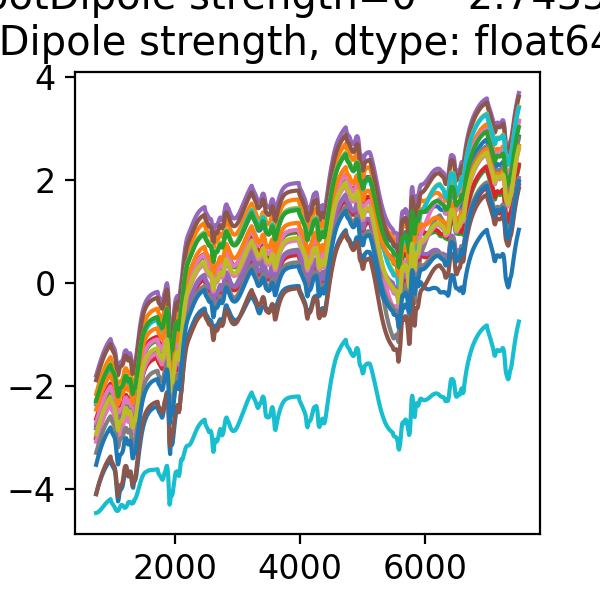

# Optimal param:	[ 6.12247778e-04 -2.27820818e+00]
# Sigma:	[1.14763769e-05 1.65825682e-01]
# Chi-square value: 	9422.766821127963


In [105]:
plt.close('all')

parameter = 'potDipole strength'

for folder in data_folders:
    # Top most level containing simulation data for each parameter
    
    cwd = os.path.join(batch_data_folder, folder)
    
    if(os.path.exists(os.path.join(cwd, 'IC_analysis'))):
        df_sim_file = pd.read_csv(os.path.join(cwd, 'IC_analysis', 'sim_file.csv'))
        
        full_path = os.path.join(cwd, df_sim_file['sim file'][0])
            
        fil = analysis.analysisTools(file = full_path)
        
        parameter_value = fil.df_metadata[parameter]
        activity_timescale = fil.df_metadata[' activity time scale']
        
        ic_analysis_folder = os.path.join(fil.rootFolder, 'IC_analysis')
        
        fil.ic_analysis_folder = ic_analysis_folder
        
        ic_folder_array = [folder for folder in os.listdir(fil.ic_analysis_folder) if not folder.endswith('.csv')]

        for ic_folder in ic_folder_array:
            # IC folder containing a ICs closely spaced apart
            
            
            # IC sim data folder containing sim data starting from above ICs.
            ic_sim_data_folder = [folder for folder in os.listdir(os.path.join(ic_analysis_folder, ic_folder))\
                                  if not folder.endswith('.hdf5') and 'IC' in folder]
            
            assert(len(ic_sim_data_folder)==1)
            # Calculate the pairwise distances for closely-spaced ICs
            df_pairwise_distances = calculate_pairwise_distance(ic_sim_folder = os.path.join(ic_analysis_folder, 
                                                                                     ic_folder, ic_sim_data_folder[0]))
            
            
            # Load these as trajectories in a format suitable for WLS fitting
            time, trajectories = load_trajectories(df = df_pairwise_distances) 
            
            # Convert to log-scale
            trajectories = np.log(trajectories)
            
            # Plot the trajectories
            plt.figure(figsize=(3,3))
            for ii in range(len(trajectories)):

                plt.plot(time, trajectories[ii])
            # plt.yscale('log')
            plt.title(parameter + '={}'.format(parameter_value)+', '+ic_folder)
            plt.show()
            
            # The analytical function to fit, its gradient, and hessian
            wlsice.init(f, df, d2f)

            guess=np.array([1, 1e-2])     # Starting point in parameter space
            min_method = "nm"           # Use Nelder-Mead minimization method

            params, sigma, chi2_min = wlsice.fit(time, trajectories, guess, min_method)

            print("# Optimal param:\t%s" % params)
            print("# Sigma:\t%s" % sigma)
            print("# Chi-square value: \t%s" % chi2_min)
            
            # Store the exponential growth and decay rate.
            # Note that we are calculating is the max of the Lyapunov spectrum
            lambda_max = params[0]
            
            df_lambda = pd.DataFrame({'lambda (fit)': lambda_max, 'Fit error':sigma[0], parameter: parameter_value, 
                                      'activity timescale':activity_timescale})
            
            df_lambda.to_csv(os.path.join(ic_analysis_folder, ic_folder, 'lyapunov_exponent.csv'))
            
            
            
            
            
            
            
    
    

## Plot the Results: Lyapunov exponents

In [106]:
batch_data_folder = '/home/deepak/ActiveFilamentsSearch_backup_3/ModellingResults/Analysis_test'
data_folders = os.listdir(batch_data_folder)


In [107]:
df_lyapunov = pd.DataFrame({})

for root, dirs, files in os.walk(batch_data_folder):
    
    for file in files:
        
        if('lyapunov' in file):
            
            df = pd.read_csv(os.path.join(root, file))
            
            df_lyapunov = df_lyapunov.append(df)

        
        

In [108]:
df_lyapunov

,Unnamed: 0,lambda (fit),Fit error,potDipole strength,activity timescale
0,0,-0.000039,0.000005,1.589744,750
0,0,-0.000297,0.000050,1.589744,750
0,0,-0.000049,0.000005,1.589744,750
0,0,-0.000053,0.000017,1.589744,750
0,0,-0.000301,0.000056,1.589744,750
0,0,-0.000414,0.000050,1.589744,750
0,0,-0.000081,0.000020,1.589744,750
0,0,-0.000156,0.000059,1.589744,750
0,0,-0.000022,0.000058,1.589744,750
0,0,-0.000033,0.000004,1.589744,750


In [110]:
# Plot the lyapunov exponent data

import seaborn as sns
%matplotlib notebook

<IPython.core.display.Javascript object>


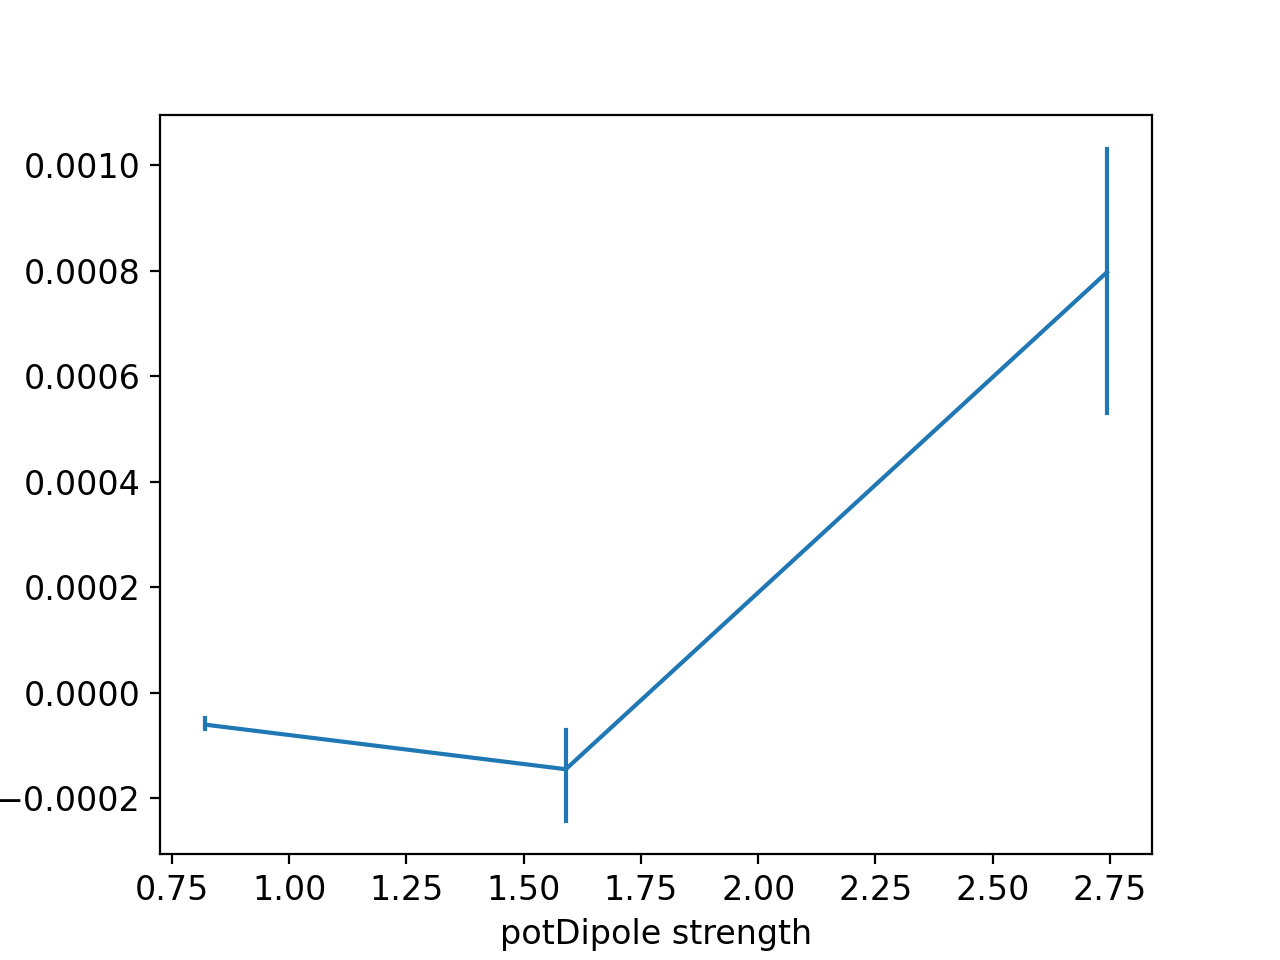

In [113]:
plt.figure()
sns.lineplot(data = df_lyapunov, x = parameter, y = 'lambda (fit)', err_style = 'bars')
plt.show()